# 0 Set up

Notes for Jacopo:


*   Cosa possiamo dire dell'evoluzione dell'IAT
*   Cosa possiamo dire dell'alterazione dell'IAT, all'incontro con un commento tossico.
Analizziamo per ogni utente in un thread, come  l'interarrival time tende a incrementare e se è legato a qualcosa che accade nell'intorno.




<br>
This EDAA  is for Walter, in order to find togheter a mattern or a signal that needs to be investigated<br>


In [29]:
kernel='j'
social='youtube'

if kernel!='Y':
  !git clone https://github.com/nudojacopo/thesis.git
  from google.colab import drive
  drive.mount('/content/drive')
  source_data='/content/drive/MyDrive/thesis/data/'+social+'/'+social+'_labeled_data_unified.parquet'
  root='/content/'
else:
  source_data='/Users/jacoponudo/Documents/thesis/data/voat/voat_labeled_data_unified.parquet'
  root='/Users/jacoponudo/Documents/'
output=root+'src/HWK/output'
output_threads=root+'src/HWK/output/temporary'
import sys
module_path = root+'thesis/src/EDA'
sys.path.append(module_path)
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from EDA_package.function import *
from scipy import stats
import random
from scipy.stats import chi2
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot

fatal: destination path 'thesis' already exists and is not an empty directory.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
import sys
import os
import numpy as np
module_path = '/Users/jacoponudo/Documents/thesis/src/EDA'
sys.path.append(module_path)
from EDA_package.function import *
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
from scipy.stats import chi2_contingency
from datetime import datetime

In [163]:
data=pd.read_csv('/content/drive/MyDrive/thesis/data/voat/voat_processed.csv',dtype={
        'comment_id': 'int',
        'sequential_number_of_comment_by_user_in_thread': 'int',
        'number_of_comments_by_user_in_thread': 'int',
        'root_submission': 'int'})
data['post_id']=data['root_submission']

In [4]:
yt=pd.read_csv('/content/drive/MyDrive/thesis/data/youtube/processed_sample.csv',dtype={
        'comment_id': 'str',
        'sequential_number_of_comment_by_user_in_thread': 'int',
        'number_of_comments_by_user_in_thread': 'int',
        'post_id': 'str'})

In [5]:
voat=pd.read_csv('/content/drive/MyDrive/thesis/data/voat/voat_processed.csv',dtype={
        'comment_id': 'int',
        'sequential_number_of_comment_by_user_in_thread': 'int',
        'number_of_comments_by_user_in_thread': 'int',
        'root_submission': 'int'})

voat['post_id']=voat['root_submission']

# 1 Interazione


## 1.1 Inter Arrival Time (IAT)

*Escludiamo le interazione con meno di 3 commenti, calcoliamo la posizione rispetto all'inizio e la fine della conversazione ∈ [0,1]*

In [ ]:
data=data[data['number_of_comments_by_user_in_thread']>2].copy()
data['position_user_thread']=data['sequential_number_of_comment_by_user_in_thread']/data['number_of_comments_by_user_in_thread']

testiamo se l'inter arrival time aumenta realemente rispetto al valore di baseline IAT_2

In [ ]:
filtered_data = data[data['sequential_number_of_comment_by_user_in_thread'] == 2]

# Group by 'user' and 'post_id' and get the max of 'IAT_user_thread'
max_iat = filtered_data.groupby(['user', 'post_id'])['IAT_user_thread'].max().reset_index()

# Rename the column to match the desired output
max_iat.rename(columns={'IAT_user_thread': 'IAT_user_thread_2'}, inplace=True)

# Merge the result with the original DataFrame on 'user' and 'post_id'
result = pd.merge(data, max_iat, on=['user', 'post_id'], how='left')

result['VariatioonIAT']=(result['IAT_user_thread']-result['IAT_user_thread_2'])/result['IAT_user_thread_2']
data=result

*L'IAT non è omogeneo nella conversazone.
Notiamo che l'inter arrival time tende a crescere nella fase finale della conversazione, l'utente si stufa, risponde sempre meno prontamente, fino a uscire.*

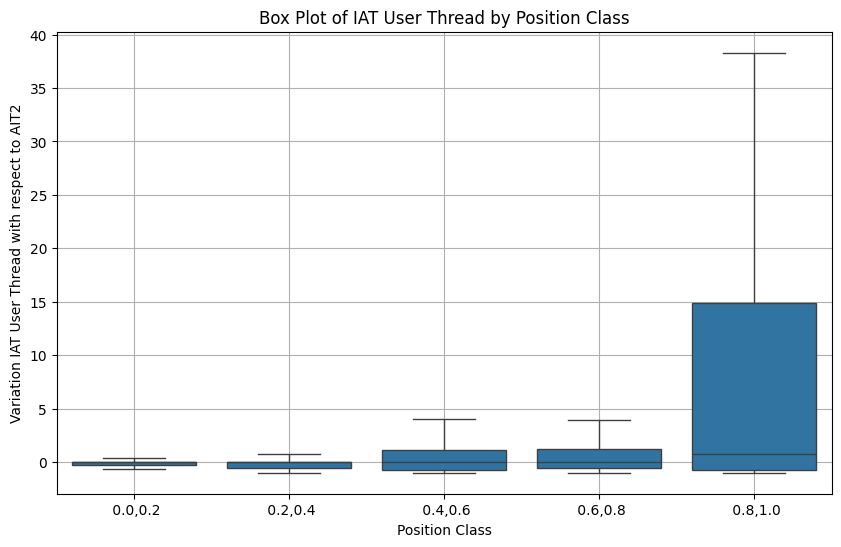

In [ ]:
number_of_classes=5
data['position_class'] = pd.cut(data['position_user_thread'], bins=number_of_classes, labels=False)

data['position_class'].value_counts()

plt.figure(figsize=(10, 6))
sns.boxplot(x='position_class', y='VariatioonIAT', data=data,showfliers=False)
plt.title('Box Plot of IAT User Thread by Position Class')
plt.xlabel('Position Class')
plt.ylabel('Variation IAT User Thread with respect to AIT2')
plt.xticks(ticks=range(number_of_classes), labels=[f' {i/number_of_classes},{(i+1)/number_of_classes}' for i in range(number_of_classes)])
plt.grid(True)
plt.show()

position_class
0    16385
1    16385
2    16385
3    16385
4    16385
Name: count, dtype: int64


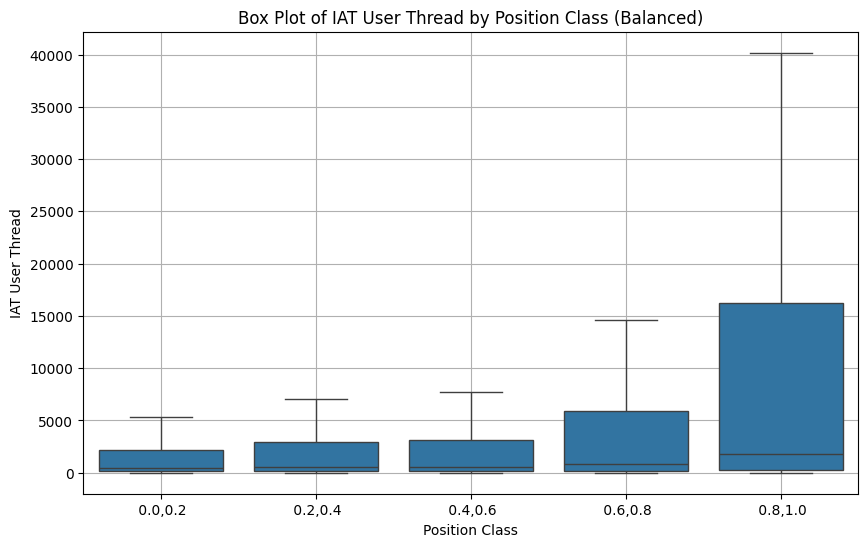

In [ ]:
from sklearn.utils import resample

# Numero minimo di osservazioni in una classe
min_class_count = min(data['position_class'].value_counts())

# Effettua l'undersampling per bilanciare il numero di osservazioni in ogni classe
balanced_data = pd.DataFrame()
for class_label in range(number_of_classes):
    class_data = data[data['position_class'] == class_label]
    balanced_class_data = resample(class_data, replace=False, n_samples=min_class_count, random_state=42)
    balanced_data = pd.concat([balanced_data, balanced_class_data])

# Ricalcola le etichette delle classi
balanced_data['position_class'] = pd.cut(balanced_data['position_user_thread'], bins=number_of_classes, labels=False)

# Visualizza il numero di osservazioni per classe
print(balanced_data['position_class'].value_counts())

# Crea il boxplot con i dati bilanciati
plt.figure(figsize=(10, 6))
sns.boxplot(x='position_class', y='IAT_user_thread', data=balanced_data, showfliers=False)
plt.title('Box Plot of IAT User Thread by Position Class (Balanced)')
plt.xlabel('Position Class')
plt.ylabel('IAT User Thread')
plt.xticks(ticks=range(number_of_classes), labels=[f' {i/number_of_classes},{(i+1)/number_of_classes}' for i in range(number_of_classes)])
plt.grid(True)
plt.show()


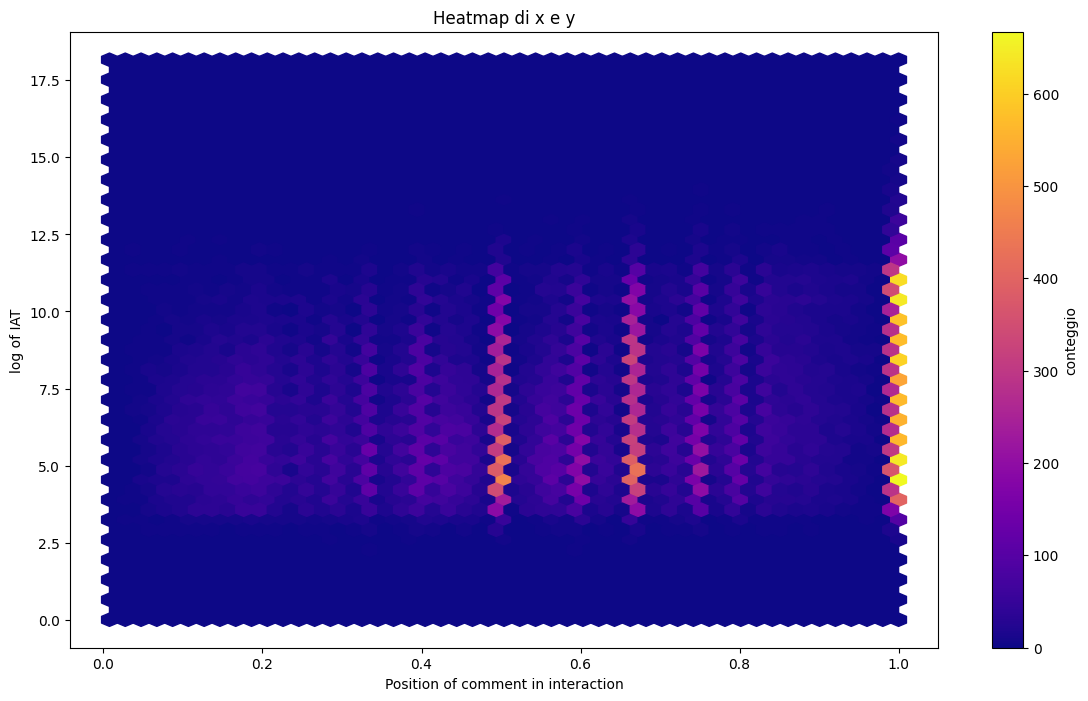

In [ ]:
plt.figure(figsize=(14, 8))  # Aumenta la dimensione della figura
plt.hexbin(
    (balanced_data['position_user_thread']),
    np.log(balanced_data['IAT_user_thread']),
    gridsize=50,  # Riduci la dimensione della griglia
    cmap='plasma'  # Cambia la colormap a 'plasma' per un migliore contrasto
)
plt.colorbar(label='conteggio')
plt.title('Heatmap di x e y')
plt.xlabel('Position of comment in interaction')
plt.ylabel('log of IAT')
plt.show()


Per ogni utente la distribuzione dei

<ipython-input-49-1bbaff52d592>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['IAT_user_thread']=df['IAT_user_thread']/60


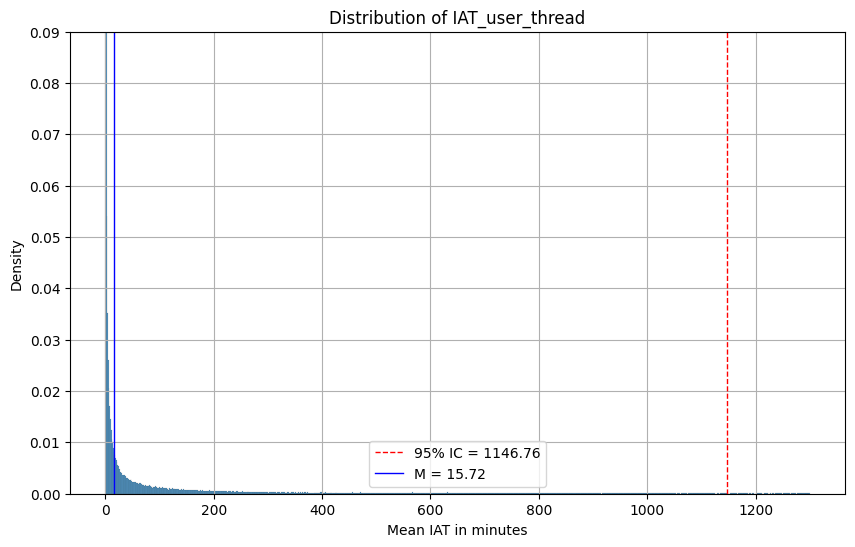

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
df=data.dropna(subset='IAT_user_thread')
df['IAT_user_thread']=df['IAT_user_thread']/60
# Assicurati di avere df2 definito correttamente
df2 = df[df['IAT_user_thread'] < 1300]

plt.figure(figsize=(10, 6))
sns.histplot(df2['IAT_user_thread'], bins=1000, stat='density')  # Set stat to 'density' for relative frequencies
plt.title('Distribution of IAT_user_thread')
plt.xlabel('Mean IAT in minutes')
plt.ylabel('Density')  # Change ylabel to reflect density instead of frequency
plt.grid(True)

# Calcolo del 95% IC per le frequenze relative
ic_95 = df['IAT_user_thread'].quantile(0.95)   # Divide per 60 per ottenere il valore in minuti

# Aggiungi una linea verticale per il 95% dell'IC
M=df['IAT_user_thread'].median()
plt.axvline(ic_95, color='red', linestyle='dashed', linewidth=1, label=f'95% IC = {ic_95:.2f}')
plt.axvline(M, color='blue',  linewidth=1,  label=f'M = {M:.2f}')
plt.legend()
plt.ylim(0,0.09)
plt.show()

In [ ]:
data['first_comment']=data.sequential_number_of_comment_by_user_in_thread==1

grouped_df=data.groupby(['first_comment','user'])['toxicity_score'].mean().reset_index()

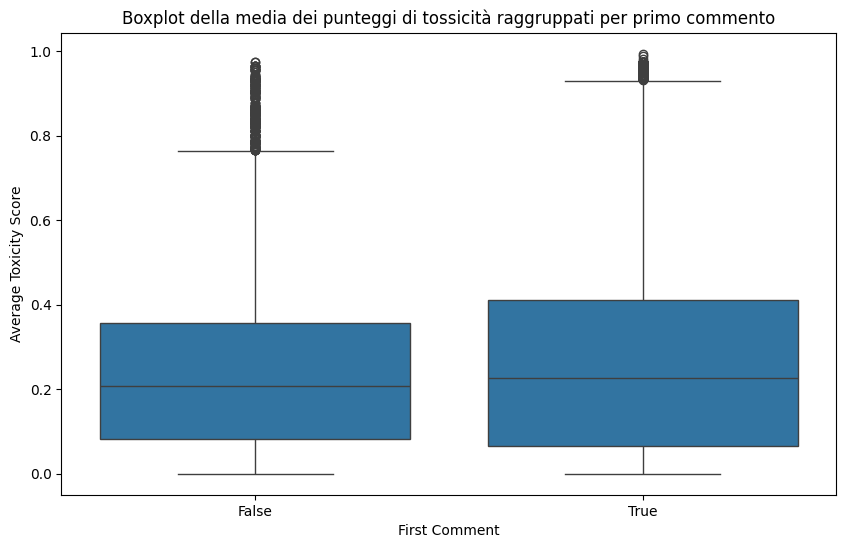

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='first_comment', y='toxicity_score', data=grouped_df)
plt.title('Boxplot della media dei punteggi di tossicità raggruppati per primo commento')
plt.xlabel('First Comment')
plt.ylabel('Average Toxicity Score')
plt.show()


### 1.1.1 IAT dentro o fuori dall'onda

In [ ]:
data=pd.read_csv('/content/drive/MyDrive/thesis/data/voat/voat_processed.csv',dtype={
        'comment_id': 'int',
        'sequential_number_of_comment_by_user_in_thread': 'int',
        'number_of_comments_by_user_in_thread': 'int',
        'root_submission': 'int'})

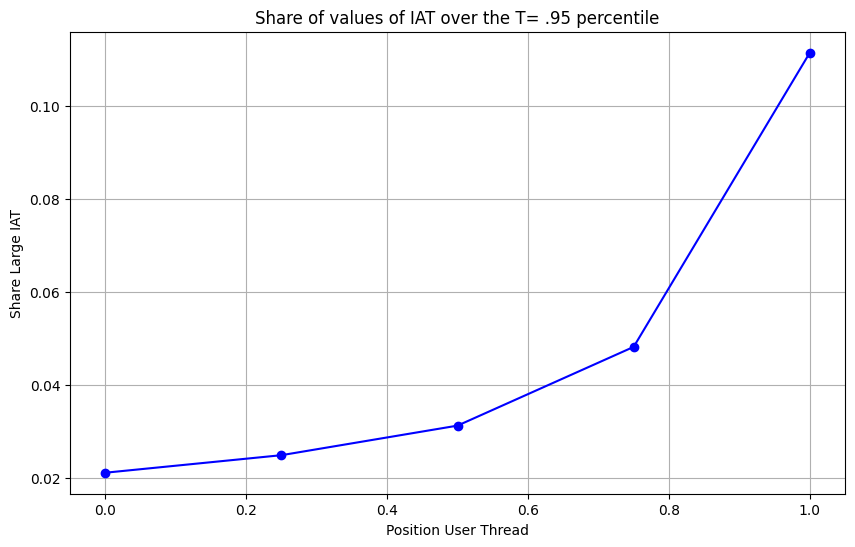

In [ ]:
data=data[data['number_of_comments_by_user_in_thread']>5].copy()
data=data.dropna(subset='IAT_user_thread')
data['position_user_thread']=data['sequential_number_of_comment_by_user_in_thread']/data['number_of_comments_by_user_in_thread']
data['position_user_thread']=data['position_user_thread'].round(1)
M=data['IAT_user_thread'].quantile(.95)
data['Large_IAT']=(data['IAT_user_thread'])>M


num_bins = 5
data['binned_position'] = pd.cut(data['position_user_thread'], bins=num_bins)
data.columns

df=data.groupby(['binned_position'])['Large_IAT'].mean().reset_index()
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(0, 1, num=num_bins)  , df['Large_IAT'], marker='o', linestyle='-', color='b')
plt.xlabel('Position User Thread')
plt.ylabel('Share Large IAT')
plt.title('Share of values of IAT over the T= .95 percentile')
plt.grid(True)
plt.show()

Mi chiedo se l'inter arrival time sia collegato al numero di commenti che arrivano nel frattempo.

Controllo se il momento in cui è fatto un commento, e l'attività nell'intorno di mezzora,   influenza la  sua coda.

In [ ]:
import pandas as pd
from tqdm import tqdm
from datetime import datetime, timedelta

# Inizializzo i vettori
shares_of_users = []
IATs = []

df = data[data['number_of_comments_by_user_in_thread'] >4 & (data['sequential_number_of_comment_by_user_in_thread'] !=1 )]

ultime_interazioni = df[df['sequential_number_of_comment_by_user_in_thread'] == df['number_of_comments_by_user_in_thread']]
ultime_interazioni = ultime_interazioni.sample(frac=1).reset_index(drop=True)

for i, ultimo in tqdm(ultime_interazioni.iterrows(),total=len(ultime_interazioni)):

  thread = df[df['root_submission'] == ultimo['root_submission']].copy()
  thread['created_at'] = pd.to_datetime(thread['created_at'])
  thread = thread.sort_values(by='created_at')

  penultimo = df[(df['sequential_number_of_comment_by_user_in_thread'] == (df['number_of_comments_by_user_in_thread'] - 1)) & (df['root_submission'] == ultimo['root_submission'])]

  datetime_str = penultimo['created_at'].values[0]
  datetime_obj = datetime.fromisoformat(datetime_str)
  plus_30 = datetime_obj + timedelta(minutes=30)
  minus_30 = datetime_obj - timedelta(minutes=30)
  N=len(thread.comment_id.unique())
  share_of_users=len(thread[(thread['created_at'] <= plus_30.isoformat()) & (thread['created_at'] > minus_30.isoformat())].comment_id.unique())/len(thread.comment_id.unique())
  last_IAT = ultimo['IAT_user_thread']

  shares_of_users.append(share_of_users)
  IATs.append(last_IAT)


# Creo un DataFrame dai vettori
df_risultati = pd.DataFrame({
    'Share_of_users': shares_of_users,
    'IAT': IATs
})

# Salvataggio del DataFrame dei risultati
df_risultati.to_csv('risultati.csv', index=False)



 19%|█▉        | 1446/7584 [00:12<00:40, 151.61it/s]<ipython-input-68-95ee64df8b9e>:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  thread['created_at'] = pd.to_datetime(thread['created_at'])
 24%|██▍       | 1805/7584 [00:16<00:56, 102.99it/s]<ipython-input-68-95ee64df8b9e>:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  thread['created_at'] = pd.to_datetime(thread['created_at'])
 26%|██▋       | 2002/7584 [00:17<00:40, 136.29it/s]<ipython-input-68-95ee64df8b9e>:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  thread['created_at'] = pd.to_datetime(thread['created_at']

Index(['comment_id', 'text', 'video_id', 'user', 'upvotes', 'downvotes',
       'depth', 'root_submission', 'topic', 'toxicity_score', 'created_at',
       'social', 'percentile',
       'sequential_number_of_comment_by_user_in_thread',
       'number_of_comments_by_user_in_thread', 'thread_birth',
       'temporal_distance_birth_h', 'thread_lifetime_h', 'number_of_users',
       'unique_words_count', 'number_of_comments', 'language',
       'unique_word_user', 'temporal_distance_from_previous_comment_h',
       'IAT_user', 'IAT_user_thread', 'IAT_thread', 'position_user_thread',
       'Large_IAT', 'binned_position'],
      dtype='object')

<Figure size 1000x600 with 0 Axes>

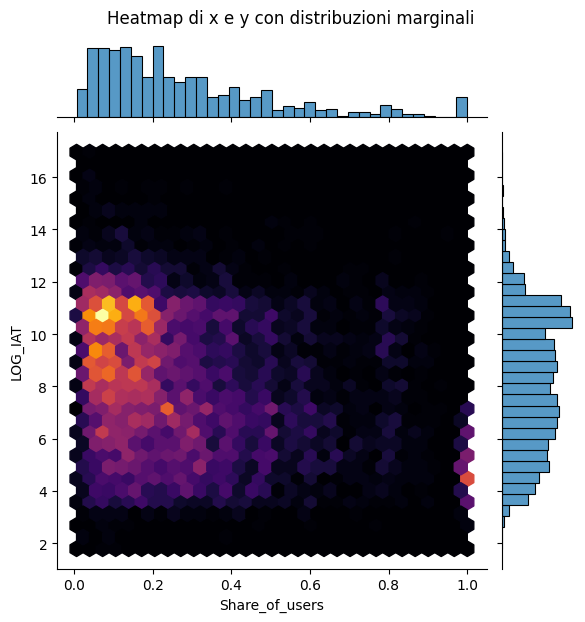

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assicurati di avere i dati preparati
df_risultati['LOG_IAT'] =np.log(df_risultati['IAT'])

# Creazione del plot con distribuzioni marginali
plt.figure(figsize=(10, 6))
g = sns.jointplot(
    x='Share_of_users',
    y='LOG_IAT',
    data=df_risultati,
    kind='hex',  # Usa una heatmap esagonale
    cmap='inferno',
    gridsize=30
)
g.ax_joint.set_xlabel('Share_of_users')
g.ax_joint.set_ylabel('LOG_IAT')
g.fig.suptitle('Heatmap di x e y con distribuzioni marginali', y=1.03)

# Mostra il plot
plt.show()


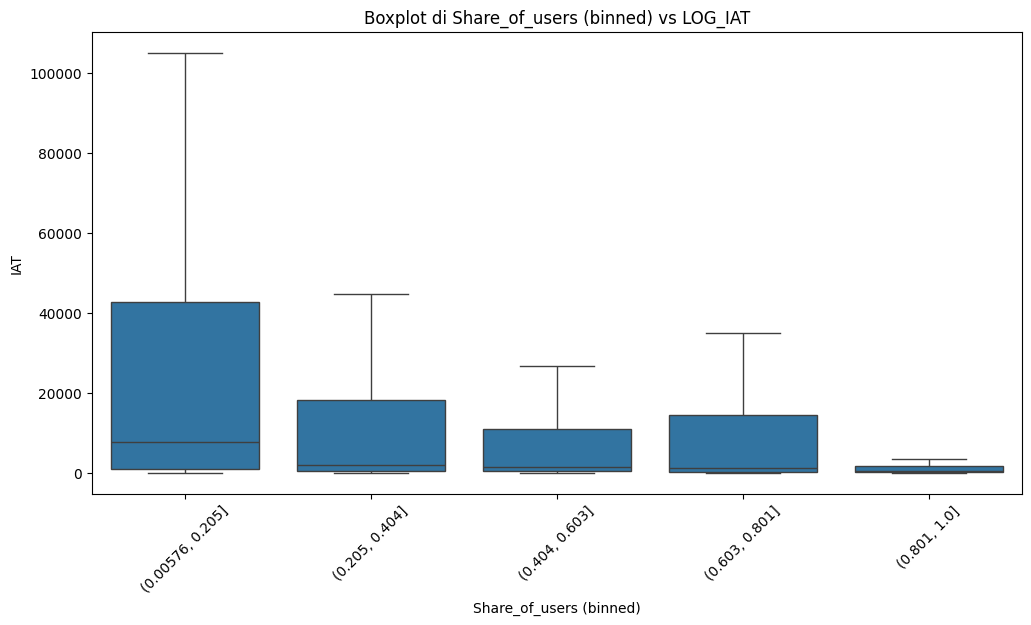

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Esempio di dati, assicurati di avere i tuoi dati nel dataframe df_risultati
# df_risultati = ...

# Creazione di una nuova colonna LOG_IAT come nel tuo esempio
df_risultati['LOG_IAT'] =(df_risultati['IAT'])

# Creazione di una colonna per i bin
df_risultati['Share_of_users_bins'] = pd.cut(df_risultati['Share_of_users'], bins=5)

# Impostazione della dimensione della figura
plt.figure(figsize=(12, 6))

# Creazione del boxplot usando i bin di Share_of_users
sns.boxplot(x='Share_of_users_bins', y='LOG_IAT', data=df_risultati,showfliers=False)

# Impostazione dei titoli degli assi e del grafico
plt.xlabel('Share_of_users (binned)')
plt.ylabel('IAT')
plt.xticks(rotation=45)  # Rotazione delle etichette sull'asse x per una migliore leggibilità
plt.title('Boxplot di Share_of_users (binned) vs LOG_IAT')

# Mostra il plot
plt.show()


L'IAT quindi si dilata quando non ci sono utenti a stimolarne la risposta.

La tossicitè tende a aumentare attorno ai 5 minuti di IAT, dopo di che decresce se i tempi si dilatano.
Mentre è molto bassa se i tempi si accorciano.

## 1.2 Inter Arrival Time e Tossicità

### 1.2.1 La tossicità e la posizione del commento nell'interazione dell'utente

Non esiste alcuna connessione tra la posizione di un commento e il suo valore di tossicità.

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

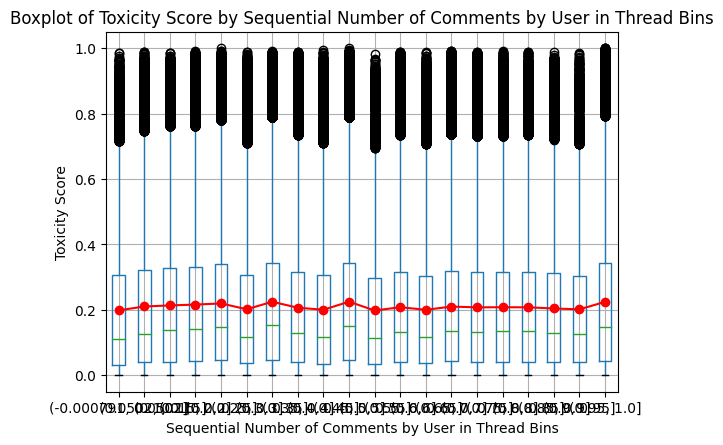

In [ ]:


plt.figure(figsize=(12, 8))
yt['position'] = yt['sequential_number_of_comment_by_user_in_thread']/yt['number_of_comments_by_user_in_thread']

# Suddivisione dei dati in 20 bin utilizzando pd.cut
bins = pd.cut(yt['position'], bins=20)

# Assegna i bin alla colonna 'bins' nel DataFrame 'yt'
yt['bins'] = bins
import numpy as np

# Calcola le medie per ciascun bin
bin_means = yt.groupby('bins')['toxicity_score'].mean()

# Traccia il boxplot
plt.figure(figsize=(12, 8))
yt.boxplot(column='toxicity_score', by='bins', grid=True)
plt.title('Boxplot of Toxicity Score by Sequential Number of Comments by User in Thread Bins')
plt.xlabel('Sequential Number of Comments by User in Thread Bins')
plt.ylabel('Toxicity Score')
plt.suptitle('')  # Rimuove il titolo automatico generato da Pandas

# Traccia una linea che connette le medie
bin_centers = np.arange(len(bin_means)) + 1
plt.plot(bin_centers, bin_means, marker='o', color='red', linestyle='-')

plt.show()


lo stesso trend si identifica su Voat

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

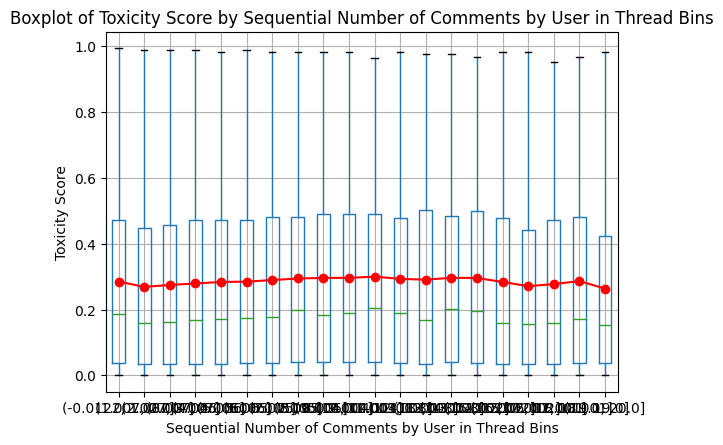

In [ ]:


plt.figure(figsize=(12, 8))
voat['position'] = voat['sequential_number_of_comment_by_user_in_thread']/yt['number_of_comments_by_user_in_thread']

# Suddivisione dei dati in 20 bin utilizzando pd.cut
bins = pd.cut(voat['position'], bins=20)

# Assegna i bin alla colonna 'bins' nel DataFrame 'yt'
voat['bins'] = bins
import numpy as np

# Calcola le medie per ciascun bin
bin_means = voat.groupby('bins')['toxicity_score'].mean()

# Traccia il boxplot
plt.figure(figsize=(12, 8))
voat.boxplot(column='toxicity_score', by='bins', grid=True)
plt.title('Boxplot of Toxicity Score by Sequential Number of Comments by User in Thread Bins')
plt.xlabel('Sequential Number of Comments by User in Thread Bins')
plt.ylabel('Toxicity Score')
plt.suptitle('')  # Rimuove il titolo automatico generato da Pandas

# Traccia una linea che connette le medie
bin_centers = np.arange(len(bin_means)) + 1
plt.plot(bin_centers, bin_means, marker='o', color='red', linestyle='-')

plt.show()


###  1.2.2 La tossicità e L'inter arrival time

<ipython-input-9-7306a1aee613>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_activity['LOG_IAT'] =np.log(user_activity['IAT_user_thread'])
<ipython-input-9-7306a1aee613>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_activity['toxicity_score_scaled'] = np.sqrt(user_activity['toxicity_score'])


<Figure size 1000x600 with 0 Axes>

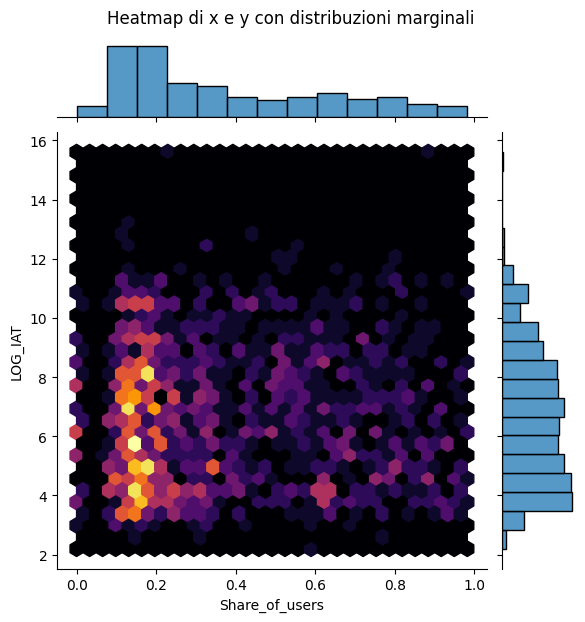

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


data['user'].value_counts()
user_activity=data[data['user']=='Blacksmith21']
# Assicurati di avere i dati preparati
user_activity['LOG_IAT'] =np.log(user_activity['IAT_user_thread'])
user_activity['toxicity_score']


user_activity['toxicity_score_scaled'] = np.sqrt(user_activity['toxicity_score'])



# Creazione del plot con distribuzioni marginali
plt.figure(figsize=(10, 6))
g = sns.jointplot(
    x='toxicity_score_scaled',
    y='LOG_IAT',
    data=user_activity,
    kind='hex',  # Usa una heatmap esagonale
    cmap='inferno',
    gridsize=30
)
g.ax_joint.set_xlabel('Share_of_users')
g.ax_joint.set_ylabel('LOG_IAT')
g.fig.suptitle('Heatmap di x e y con distribuzioni marginali', y=1.03)

# Mostra il plot
plt.show()


<Figure size 1200x800 with 0 Axes>

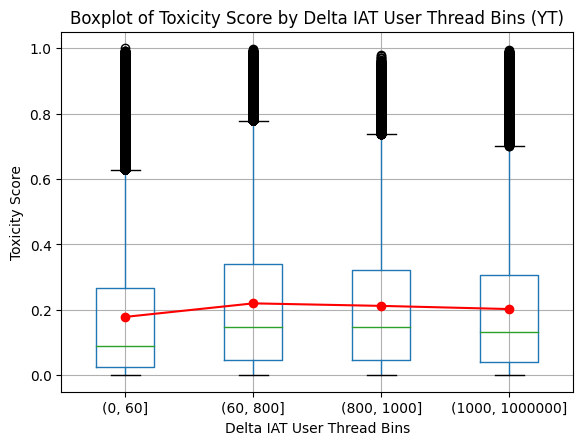

Test t per il dataset yt:
Test tra gruppi 1 e 2:
t-statistic: -101.75754506417796
P-value: 0.0
Test tra gruppi 1 e 3:
t-statistic: -33.87265446208398
P-value: 3.700299200038915e-251
Test tra gruppi 1 e 4:
t-statistic: -58.713797081350656
P-value: 0.0
Test tra gruppi 2 e 3:
t-statistic: 7.865712107288254
P-value: 3.673182253816944e-15
Test tra gruppi 2 e 4:
t-statistic: 55.96047879725568
P-value: 0.0
Test tra gruppi 3 e 4:
t-statistic: 10.44989126202484
P-value: 1.4723850354061136e-25


NameError: name 'voat' is not defined

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Suddividi 'delta_IAT_user_thread' in bins per yt dataset
yt['delta_IAT_user_thread'] = yt.groupby('user')['IAT_user_thread'].pct_change()


intervalli = [0, 60, 800,1000,1000000]

# Creiamo i bins manualmente utilizzando gli intervalli definiti
yt['bins'] = pd.cut(yt['IAT_user_thread'], bins=intervalli)

yt=yt.dropna(subset=['toxicity_score','bins'])
yt[['IAT_user_thread','bins']]
# Crea i boxplot per yt dataset
plt.figure(figsize=(12, 8))
yt.boxplot(column='toxicity_score', by='bins', grid=True)
plt.title('Boxplot of Toxicity Score by Delta IAT User Thread Bins (YT)')
plt.xlabel('Delta IAT User Thread Bins')
plt.ylabel('Toxicity Score')
plt.suptitle('')  # Rimuove il titolo automatico generato da Pandas
bin_means = yt.groupby('bins')['toxicity_score'].mean()
# Traccia una linea rossa che connette le medie
bin_centers = range(1,len(bin_means)+1)
plt.plot(bin_centers, bin_means, marker='o', color='red', linestyle='-')

plt.show()

# Esegui il test t tra tutte le coppie di gruppi per yt dataset
yt_groups = [group['toxicity_score'].values for name, group in yt.groupby('bins')]

print("Test t per il dataset yt:")
for i in range(len(yt_groups)):
    for j in range(i+1, len(yt_groups)):
        group1 = yt_groups[i]
        group2 = yt_groups[j]
        t_stat, p_val = ttest_ind(group1, group2)
        print(f"Test tra gruppi {i+1} e {j+1}:")
        print(f"t-statistic: {t_stat}")
        print(f"P-value: {p_val}")

# Suddividi 'delta_IAT_user_thread' in bins per voat dataset
voat['delta_IAT_user_thread'] = voat.groupby('user')['IAT_user_thread'].pct_change()

voat['bins'] = pd.cut(voat['IAT_user_thread'], bins=intervalli)
voat=voat.dropna(subset=['toxicity_score','bins'])

# Crea i boxplot per voat dataset
plt.figure(figsize=(12, 8))
voat.boxplot(column='toxicity_score', by='bins', grid=True)
plt.title('Boxplot of Toxicity Score by Delta IAT User Thread Bins (Voat)')
plt.xlabel('Delta IAT User Thread Bins')
plt.ylabel('Toxicity Score')
plt.suptitle('')  # Rimuove il titolo automatico generato da Pandas
bin_means = voat.groupby('bins')['toxicity_score'].mean()

# Traccia una linea rossa che connette le medie
bin_centers = range(1,len(bin_means)+1)
plt.plot(bin_centers, bin_means, marker='o', color='red', linestyle='-')

plt.show()

# Esegui il test t tra tutte le coppie di gruppi per voat dataset
voat_groups = [group['toxicity_score'].values for name, group in voat.groupby('bins')]

print("\nTest t per il dataset voat:")
for i in range(len(voat_groups)):
    for j in range(i+1, len(voat_groups)):
        group1 = voat_groups[i]
        group2 = voat_groups[j]
        t_stat, p_val = ttest_ind(group1, group2)
        print(f"Test tra gruppi {i+1} e {j+1}:")
        print(f"t-statistic: {t_stat}")
        print(f"P-value: {p_val}")


###  1.2.3 la trappola della discussione

Entrare in una conversazione dove si sta discutendo qualcosa aumenta la probabilità che mi fermi a discutere per piu di un commento

<ipython-input-84-39ffbf878b5d>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread['color'] = thread['user'].apply(lambda x: 'red' if x in multiple_posts_users else 'blue')


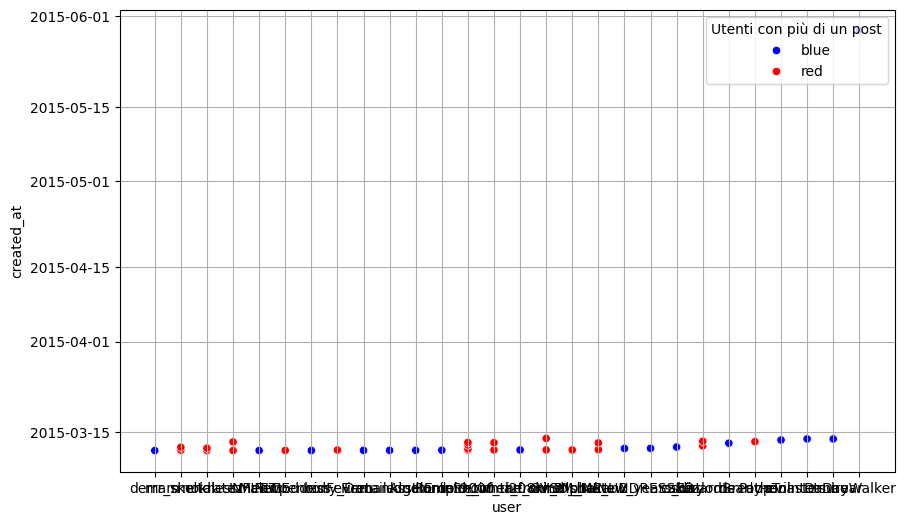

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Supponiamo che 'data' sia il DataFrame contenente i dati della conversazione

# Filtraggio del thread specifico
thread = data[data['post_id'] == 62112]

# Identificazione degli utenti che sono presenti più di una volta
user_counts = thread['user'].value_counts()
multiple_posts_users = user_counts[user_counts > 1].index

# Creazione di una nuova colonna 'color' che indica se l'utente deve essere colorato in giallo
thread['color'] = thread['user'].apply(lambda x: 'red' if x in multiple_posts_users else 'blue')

# Creazione del grafico con seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(x='user', y='created_at', data=thread, hue='color', palette={'red': 'red', 'blue': 'blue'})

plt.legend(title='Utenti con più di un post', loc='upper right')
plt.grid(True)
plt.show()
plt.show()



In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Supponiamo che 'data' sia il DataFrame contenente i dati della conversazione

# Filtraggio del thread specifico
thread = data[data['post_id'] == 62112]

# Identificazione degli utenti che sono presenti più di una volta
user_counts = thread['user'].value_counts()
multiple_posts_users = user_counts[user_counts > 1].index

# Creazione di una nuova colonna 'color' che indica se l'utente deve essere colorato in giallo
thread['color'] = thread['user'].apply(lambda x: 'red' if x in multiple_posts_users else 'blue')
thread=thread[thread['color']=='red']
# Creazione del grafico con seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(x='user', y='created_at', data=thread, hue='color')

plt.legend(title='Utenti con più di un post', loc='upper right')
plt.grid(True)
plt.show()
plt.show()



In [ ]:
import numpy as np
from tqdm import tqdm
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Supponiamo che data sia il DataFrame che contiene i dati
# Assicurati di adattare questa parte del codice ai tuoi dati effettivi

X_list = []  # Lista per salvare i dati di input
y_list = []  # Lista per salvare i target

max_sequence_length = 0
data['created_at'] = pd.to_datetime(data['created_at'])
data['time'] = pd.to_numeric(data['created_at'])
for thread_id in tqdm(data[:10000].post_id.unique()):
    thread=data[data['post_id'] == thread_id].copy()
    thread['user_id'] = thread.groupby('user').ngroup()
    x_user = thread[['time', 'user_id']].values
    y_user = (thread['toxicity_score']>0.6)

    X_list.append(x_user)
    y_list.append(y_user)

    if len(x_user) > max_sequence_length:
        max_sequence_length = len(x_user)

# Padding delle sequenze per uniformarle in lunghezza
X_train_padded = pad_sequences(X_list, maxlen=max_sequence_length, padding='post')
y_train_padded = pad_sequences(y_list, maxlen=max_sequence_length, padding='post')

# Convertiamo le liste in array numpy
X_train = np.array(X_train_padded)
y_train = np.array(y_train_padded)

print("Dimensioni di X_train:", X_train.shape)
print("Dimensioni di y_train:", y_train.shape)


100%|██████████| 121/121 [00:01<00:00, 112.98it/s]

Dimensioni di X_train: (121, 644, 2)
Dimensioni di y_train: (121, 644)



/usr/local/lib/python3.10/dist-packages/keras/src/utils/data_utils.py:1132: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


In [ ]:
from sklearn.model_selection import train_test_split

# Suddividiamo i dati in set di addestramento e di test
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print("Dimensioni di X_train:", X_train.shape)
print("Dimensioni di X_test:", X_test.shape)


Dimensioni di X_train: (4240, 644, 2)
Dimensioni di X_test: (1060, 644, 2)


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Definizione del modello
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(644, 2)),  # Modifying input shape to (2418, 2)
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Using sigmoid activation to ensure output is between 0 and 1
])


# Compilazione del modello
model.compile(optimizer='adam',
              loss='mean_squared_error',  # utilizziamo il mean squared error come funzione di loss
              metrics=['mean_squared_error'])

# Addestramento del modello
model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))


Epoch 1/100
4/4 [==============================] - 5s 662ms/step - loss: 0.2577 - mean_squared_error: 0.2577 - val_loss: 0.1259 - val_mean_squared_error: 0.1259
Epoch 2/100
4/4 [==============================] - 2s 485ms/step - loss: 0.2568 - mean_squared_error: 0.2568 - val_loss: 0.1253 - val_mean_squared_error: 0.1253
Epoch 3/100
4/4 [==============================] - 2s 515ms/step - loss: 0.2559 - mean_squared_error: 0.2559 - val_loss: 0.1247 - val_mean_squared_error: 0.1247
Epoch 4/100
4/4 [==============================] - 2s 537ms/step - loss: 0.2550 - mean_squared_error: 0.2550 - val_loss: 0.1242 - val_mean_squared_error: 0.1242
Epoch 5/100
4/4 [==============================] - 2s 495ms/step - loss: 0.2542 - mean_squared_error: 0.2542 - val_loss: 0.1236 - val_mean_squared_error: 0.1236
Epoch 6/100
4/4 [==============================] - 1s 337ms/step - loss: 0.2533 - mean_squared_error: 0.2533 - val_loss: 0.1231 - val_mean_squared_error: 0.1231
Epoch 7/100
4/4 [=================

34/34 [==============================] - 1s 13ms/step


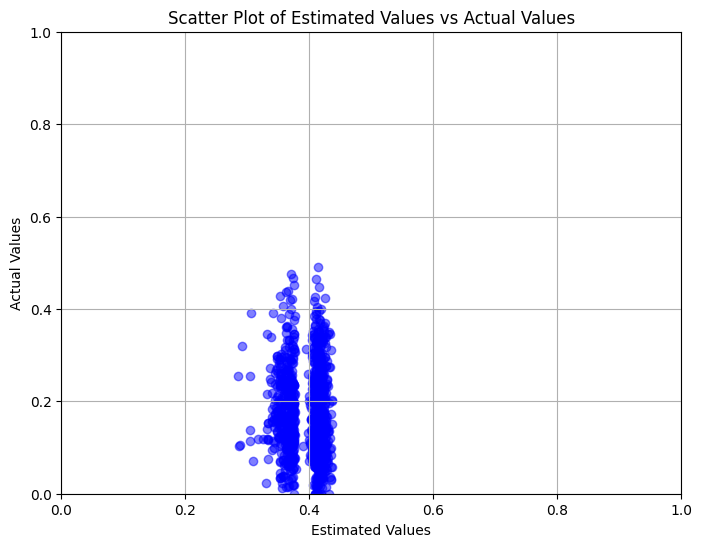

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Make predictions
predictions = model.predict(X_test)

# Flatten the predictions and actual values

average_predictions = np.mean(predictions, axis=1)

y_test_flat = np.ravel(y_test)

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(average_predictions, y_test_flat, color='blue', alpha=0.5)
plt.title('Scatter Plot of Estimated Values vs Actual Values')
plt.xlabel('Estimated Values')
plt.ylabel('Actual Values')
plt.xlim(0,1)
plt.ylim(0,1)
plt.grid(True)
plt.show()


In [ ]:

import pandas as pd
from tqdm import tqdm

# Assicurati che 'created_at' sia di tipo datetime
data['created_at'] = pd.to_datetime(data['created_at'])

# Seleziona un campione di 1000 commenti iniziali
primi_commenti = data[data['sequential_number_of_comment_by_user_in_thread'] == 1].sample(10000)

# Lista per memorizzare le informazioni della chat
chat_info_list = []

# Itera attraverso il campione di commenti iniziali
for i, row in tqdm(primi_commenti.iterrows(), total=len(primi_commenti)):
    thread = data[(data['post_id'] == row['post_id']) & (data['user'] != row['user'])]
    window_min = pd.Timestamp(row['created_at']) - pd.Timedelta(minutes=60)
    window_max = pd.Timestamp(row['created_at']) + pd.Timedelta(minutes=60)
    thread_in_window = thread[(thread['created_at'] <= window_max) & (thread['created_at'] > window_min)]

    verbosity_user =row['number_of_comments_by_user_in_thread']
    verbosity_chat = thread_in_window['comment_id'].nunique() / thread_in_window['user'].nunique() if thread_in_window['user'].nunique() != 0 else 0
    users_in_chat = thread_in_window['user'].nunique()
    comments_in_chat = thread_in_window['comment_id'].nunique()

    # Aggiungi le informazioni alla lista
    chat_info_list.append({
        'post_id': row['post_id'],
        'user': row['user'],
        'created_at': row['created_at'],
        'verbosity_user': verbosity_user-1,
        'verbosity_chat': verbosity_chat,
        'users_in_chat': users_in_chat,
        'comments_in_chat': thread_in_window[thread_in_window['sequential_number_of_comment_by_user_in_thread']>1]['comment_id'].nunique(),
        'tossicità_nella_finestra':thread_in_window['toxicity_score'].mean()
    })

# Crea un DataFrame dalle informazioni della chat
chat_info_df = pd.DataFrame(chat_info_list)

# Mostra il DataFrame risultante
print(chat_info_df.head())







100%|██████████| 10000/10000 [07:27<00:00, 22.35it/s]


   post_id                 user                created_at  verbosity_user  \
0  3143638                  Lal 2019-04-07 02:49:58+00:00               0   
1  3477478             ArcAngel 2019-10-19 04:30:34+00:00               0   
2  1226852         shittersfull 2016-08-12 19:43:07+00:00               0   
3  2549725         Chempergrill 2018-05-17 15:34:10+00:00               0   
4  2316333  gentlemanadventurer 2018-01-01 00:54:39+00:00               0   

   verbosity_chat  users_in_chat  comments_in_chat  tossicità_nella_finestra  
0        1.583333             12                 9                  0.316216  
1        1.000000              4                 0                  0.135872  
2        1.000000              1                 0                  0.939145  
3        1.666667              6                 4                  0.274592  
4        1.500000             14                 8                  0.329437  


In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import pandas as pd

# Carica il dataset
# Assicurati di sostituire 'nome_file.csv' con il percorso del tuo dataset
dataset = chat_info_df.dropna()

# Seleziona le feature e il target
X = dataset[[ 'verbosity_chat', 'users_in_chat', 'comments_in_chat','tossicità_nella_finestra']]
y = dataset['verbosity_user']>1


# Dividi il dataset in set di addestramento e set di test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crea il modello di albero di regressione
model = DecisionTreeRegressor(random_state=42)

# Addestra il modello
model.fit(X_train, y_train)

# Ottieni l'importanza delle feature
feature_importance = model.feature_importances_

# Crea un DataFrame per visualizzare l'importanza delle feature
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("Variabili più significative:")
print(feature_importance_df)


Variabili più significative:
                    Feature  Importance
3  tossicità_nella_finestra    0.616846
0            verbosity_chat    0.132794
1             users_in_chat    0.127096
2          comments_in_chat    0.123264


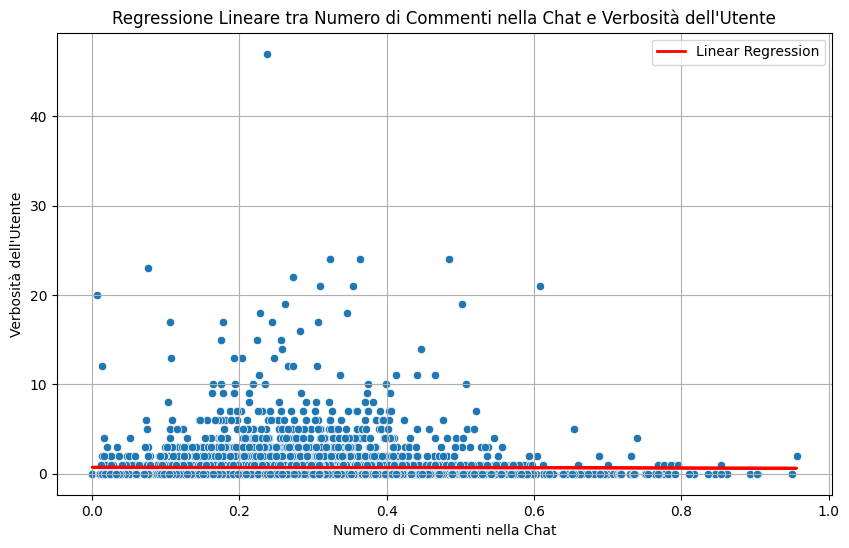


Summary del modello di regressione lineare:
Coefficiente della retta di regressione (pendenza): -0.11192574230156954
Intercetta della retta di regressione: 0.7285439636781502
Coefficiente di correlazione: -0.00709548755964857


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import numpy as np
chat_info_df=chat_info_df.dropna(subset=['verbosity_user','tossicità_nella_finestra'])
# Estrai le features (X) e il target (y)
X = chat_info_df[['tossicità_nella_finestra']]
y = chat_info_df['verbosity_user']

# Crea un'istanza del modello di regressione lineare
model = LinearRegression()

# Addestra il modello
model.fit(X, y)

# Ottieni i coefficienti della retta di regressione
slope = model.coef_[0]
intercept = model.intercept_

# Calcola il coefficiente di correlazione
correlation = np.corrcoef(X.values.T, y.values)[0, 1]

# Plot della regressione lineare
plt.figure(figsize=(10, 6))
sns.scatterplot(x='tossicità_nella_finestra', y='verbosity_user', data=chat_info_df)
plt.plot(X, model.predict(X), color='red', linewidth=2, label='Linear Regression')
plt.title('Regressione Lineare tra Numero di Commenti nella Chat e Verbosità dell\'Utente')
plt.xlabel('Numero di Commenti nella Chat')
plt.ylabel('Verbosità dell\'Utente')
plt.legend()
plt.grid(True)
plt.show()

# Summary
print("\nSummary del modello di regressione lineare:")
print("Coefficiente della retta di regressione (pendenza):", slope)
print("Intercetta della retta di regressione:", intercept)
print("Coefficiente di correlazione:", correlation)


In [ ]:
chat_info_df['is_toxic']=chat_info_df['toxicity_score']>0.6

,post_id,user,created_at,verbosity_user,verbosity_chat,users_in_chat,comments_in_chat,tossicità_nella_finestra,toxicity_score,is_toxic
0,1542192,VIP740,2017-01-06 19:36:30+00:00,0,1.000000,1,1,0.021786,0.851736,True
1,3294995,capnflummox,2019-06-24 16:48:59+00:00,2,3.500000,2,6,0.203157,0.974994,True
2,2727903,RonBennington,2018-09-18 20:07:00+00:00,0,1.076923,13,2,0.159401,0.939145,True
3,3345884,RonBennington,2019-07-21 22:30:36+00:00,0,1.000000,7,0,0.395433,0.939145,True
4,2547202,RonBennington,2018-05-16 05:19:20+00:00,0,1.400000,5,6,0.203336,0.939145,True
...,...,...,...,...,...,...,...,...,...,...
4702,3366333,Bonnie564,2019-08-04 17:30:21+00:00,2,1.388889,18,9,0.140669,0.376946,False
4703,330506,ragefactor11,2015-07-23 04:44:33+00:00,1,1.166667,18,5,0.372949,0.396957,False
4704,536443,Tisias,2015-09-24 01:24:52+00:00,0,1.333333,21,6,0.208682,0.840319,True
4705,3050194,Scottfree,2019-02-21 04:01:54+00:00,0,1.000000,3,0,0.639303,0.749544,True


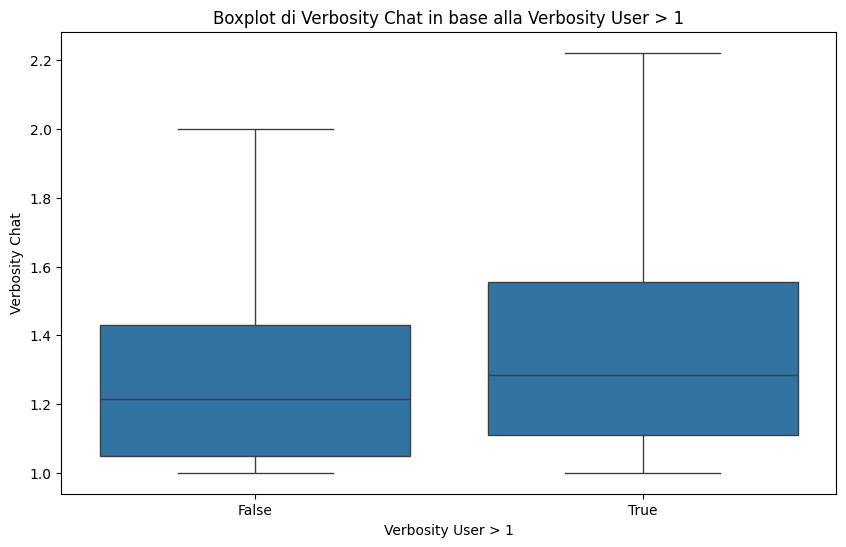

Test Statistic: 5.463515893459868
P-value: 4.787124890926354e-08
La differenza tra le due distribuzioni è significativa (reject H0)


In [ ]:
df=chat_info_df.dropna()
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['verbosity_user']>1, y=df['verbosity_chat'],showfliers=False)
plt.xlabel('Verbosity User > 1')
plt.ylabel('Verbosity Chat')
plt.title('Boxplot di Verbosity Chat in base alla Verbosity User > 1')
plt.show()

from scipy import stats

# Creazione dei due campioni
group1 = df[df['verbosity_user'] > 1]['verbosity_chat']
group2 = df[df['verbosity_user'] <= 1]['verbosity_chat']

# Esecuzione del test t
t_statistic, p_value = stats.ttest_ind(group1, group2)

# Stampa dei risultati
print("Test Statistic:", t_statistic)
print("P-value:", p_value)

# Interpretazione del risultato
alpha = 0.05
if p_value < alpha:
    print("La differenza tra le due distribuzioni è significativa (reject H0)")
else:
    print("Non c'è sufficiente evidenza per concludere che le due distribuzioni siano diverse (fail to reject H0)")


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Figure size 1000x600 with 0 Axes>

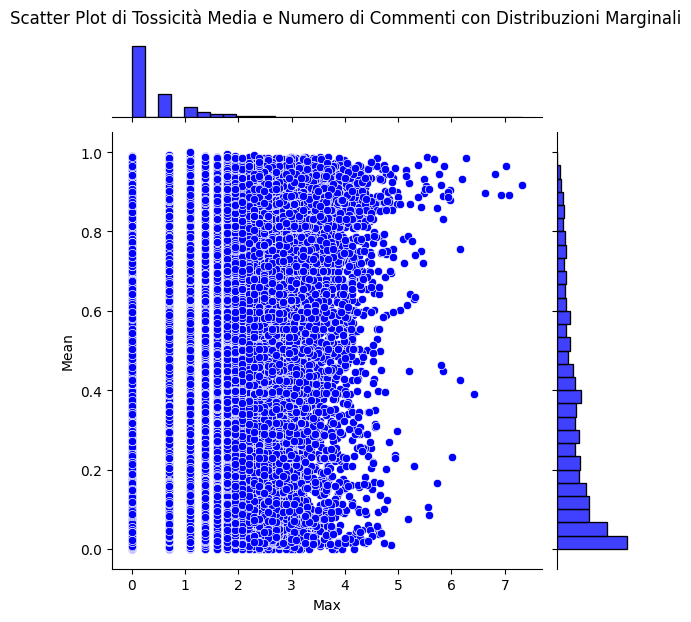

In [ ]:
yt['is_toxic']=yt['toxicity_score']>0.6

import matplotlib.pyplot as plt
import seaborn as sns

# Calcola la media della tossicità per post
post_user_activity = yt.groupby(['user','post_id'])['comment_id'].count().reset_index()
post_user_activity_max=post_user_activity.groupby('user')['comment_id'].max().reset_index()
# Calcola il numero di commenti per post
post_user_activity_mean=yt.groupby('user')['toxicity_score'].max().reset_index()

# Combina i due DataFrame in uno solo
combined_data = post_user_activity_max.merge(post_user_activity_mean, on='user')
combined_data['MAX']=np.log(combined_data['comment_id'])
combined_data['Mean']=np.log(combined_data['toxicity_score'])

# Creazione del plot con distribuzioni marginali
plt.figure(figsize=(10, 6))
g = sns.jointplot(
    x='MAX',
    y='toxicity_score',
    data=combined_data,
    kind='scatter',  # Usa un plot a punti
    color='blue',
    marginal_kws=dict(bins=30, fill=True)
)
g.ax_joint.set_xlabel('Max')
g.ax_joint.set_ylabel('Mean')
g.fig.suptitle('Scatter Plot di Tossicità Media e Numero di Commenti con Distribuzioni Marginali', y=1.03)

# Mostra il plot
plt.show()


# NOT **VALIDATED**

## TRA

In [153]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# Assicurati che 'created_at' sia di tipo datetime
data['created_at'] = pd.to_datetime(data['created_at'])

# Filtra i commenti attivi
sample_size=10
sample = data[data['sequential_number_of_comment_by_user_in_thread']==1].sample(sample_size)

comment_results = []

for i, row in tqdm(sample.iterrows(),total=sample_size):
    thread = data[(data['post_id'] == row['post_id']) & (data['user'] != row['user'])]
    window_min = row['created_at'] - pd.Timedelta(minutes=60)
    window_max = row['created_at']
    thread_in_window = thread[(thread['created_at'] <= window_max) & (thread['created_at'] > window_min)]

    share_of_comments_in_W = (thread_in_window['comment_id'].nunique() / thread['comment_id'].nunique()) if thread['comment_id'].nunique() != 0 else np.nan
    comments_in_W = thread_in_window['comment_id'].nunique()

    comment_results.append({
        'comment_id': row['comment_id'],
        'post_id': row['post_id'],
        'user': row['user'],
        'created_at': row['created_at'],
        'toxicity_score': row['toxicity_score'],
        'partecipation': (thread_in_window['comment_id'].nunique() / thread_in_window['user'].nunique()) if thread_in_window['user'].nunique() != 0 else np.nan,
        'share_of_comments_in_W': share_of_comments_in_W,
        'comments_in_W': comments_in_W,
        'user_in_W': thread_in_window['user'].nunique(),
        'toxicity_in_W': (thread_in_window['toxicity_score'] > 0.6).sum()
    })

results_df=pd.DataFrame(comment_results)


100%|██████████| 10/10 [00:00<00:00, 14.74it/s]


In [215]:
import pandas as pd

# ... your sample data (df)
thread['is_toxic']=thread['toxicity_score']>0.6
df=thread.copy()
#df=df[['created_at','is_toxic']]

# Convert created_at to datetime if not already
df['created_at'] = pd.to_datetime(df['created_at'])

# Define window in units of periods (e.g., minutes, hours)
window = '100h'  # Adjust this value based on your data (e.g., 60 for 1 hour)

# Set index to 'created_at' (if not already set)
df.set_index('created_at', inplace=True)  # Optional, but recommended

# Handle missing values in toxicity_score (optional)
# df['toxicity_score'].fillna(value=0, inplace=True)  # Replace with your strategy

# Calculate average toxicity within the window for each post
rolling_toxicity = df.rolling('2h' ).agg({'is_toxic':'sum'}).reset_index()
df=rolling_toxicity.merge(df, on='created_at')
df=df['is_toxic_y']-df['is_toxic_y'].astype('int')

In [191]:


rolling_toxicity = df.groupby('post_id').rolling('2h').agg({'is_toxic':'mean'})

is_toxic
post_id created_at                         
3342676 2019-07-19 19:19:56+00:00  1.000000
        2019-07-19 19:20:10+00:00  1.000000
        2019-07-19 19:43:28+00:00  0.666667
        2019-07-19 19:44:07+00:00  0.500000
        2019-07-19 19:54:40+00:00  0.600000
...                                     ...
        2019-07-20 04:30:06+00:00  0.000000
        2019-07-21 02:45:19+00:00  0.000000
        2019-07-21 10:34:34+00:00  1.000000
        2019-07-21 17:20:20+00:00  0.000000
        2019-08-09 06:38:00+00:00  0.000000

[65 rows x 1 columns]

In [127]:

df=results_df
df['share']=(df['toxicity_in_W']/df['comments_in_W']).round(1)

<ipython-input-127-a8d75d451f8c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df['share']>0.7]['share']=0.7


In [128]:

import pandas as pd
# Contiamo il numero di occorrenze di ogni valore nella colonna 'share'
value_counts = df['share'].value_counts()

# Troviamo la dimensione minima tra le categorie (per il campionamento)
min_count = int(value_counts.mean())

# Eseguiamo un campionamento casuale stratificato per ogni valore nella colonna 'share'
balanced_df = df.groupby('share').apply(lambda x: x.sample(min_count,replace=True)).reset_index(drop=True)


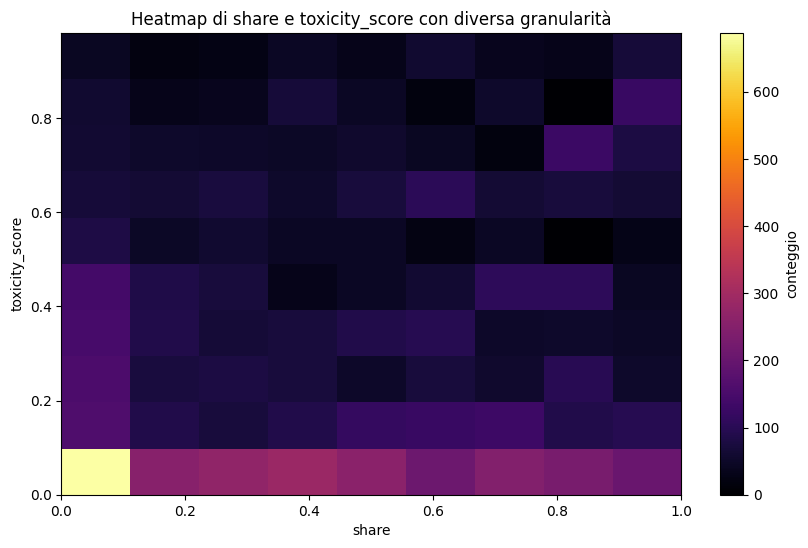

In [129]:
import matplotlib.pyplot as plt

# Supponiamo che balanced_df sia il DataFrame bilanciato

# Creiamo la figura
plt.figure(figsize=(10, 6))

# Utilizziamo plt.hist2d per creare una griglia con granularità diversa su x e y
plt.hist2d(balanced_df['share'], balanced_df['toxicity_score'], bins=[9, 10], cmap='inferno')

# Aggiungiamo la barra colore
plt.colorbar(label='conteggio')

# Impostiamo il titolo e le etichette degli assi
plt.title('Heatmap di share e toxicity_score con diversa granularità')
plt.xlabel('share')
plt.ylabel('toxicity_score')

# Mostriamo il grafico
plt.show()


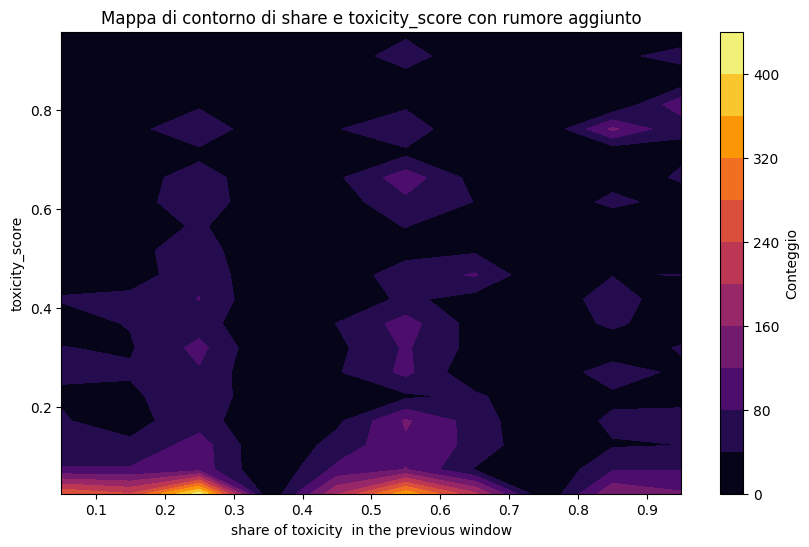

In [130]:
import numpy as np
import matplotlib.pyplot as plt

# Supponiamo che balanced_df sia il DataFrame bilanciato

# Creiamo i dati per la griglia con rumore aggiunto a x
np.random.seed(42)  # Per la riproducibilità
x = balanced_df['share']
y =( balanced_df['toxicity_score'])

# Definiamo la griglia con granularità diversa per x e y
x_bins = 10
y_bins = 20

# Creiamo la griglia dei dati
H, xedges, yedges = np.histogram2d(x, y, bins=[x_bins, y_bins])

# Creiamo i punti centrali dei bin per x e y
x_centers = (xedges[:-1] + xedges[1:]) / 2
y_centers = (yedges[:-1] + yedges[1:]) / 2

# Creiamo la figura
plt.figure(figsize=(10, 6))

# Creiamo il grafico con linee di livello
plt.contourf(x_centers, y_centers, H.T, cmap='inferno', levels=10)

# Aggiungiamo la barra colore
plt.colorbar(label='Conteggio')

# Impostiamo il titolo e le etichette degli assi
plt.title('Mappa di contorno di share e toxicity_score con rumore aggiunto')
plt.xlabel('share of toxicity  in the previous window')
plt.ylabel('toxicity_score')

# Mostriamo il grafico
plt.show()



In [131]:

import pandas as pd

df=df[df['share']<0.8]
# Contiamo il numero di occorrenze di ogni valore nella colonna 'share'
value_counts = df['share'].value_counts()

# Troviamo la dimensione minima tra le categorie (per il campionamento)
min_count = int(value_counts.min())

# Eseguiamo un campionamento casuale stratificato per ogni valore nella colonna 'share'
balanced_df = df.groupby('share').apply(lambda x: x.sample(min_count,replace=True)).reset_index(drop=True)


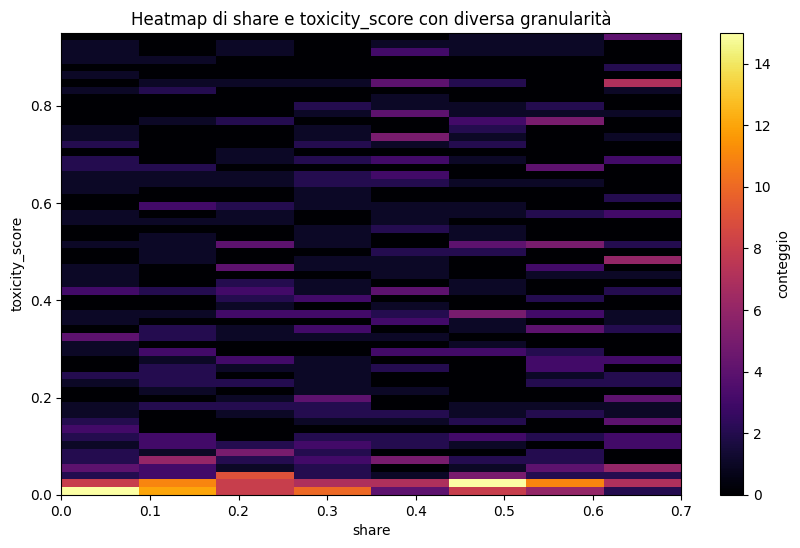

In [132]:
import matplotlib.pyplot as plt

# Supponiamo che balanced_df sia il DataFrame bilanciato

# Creiamo la figura
plt.figure(figsize=(10, 6))

# Utilizziamo plt.hist2d per creare una griglia con granularità diversa su x e y
plt.hist2d(balanced_df['share'], balanced_df['toxicity_score'], bins=[8, 60], cmap='inferno')

# Aggiungiamo la barra colore
plt.colorbar(label='conteggio')

# Impostiamo il titolo e le etichette degli assi
plt.title('Heatmap di share e toxicity_score con diversa granularità')
plt.xlabel('share')
plt.ylabel('toxicity_score')

# Mostriamo il grafico
plt.show()


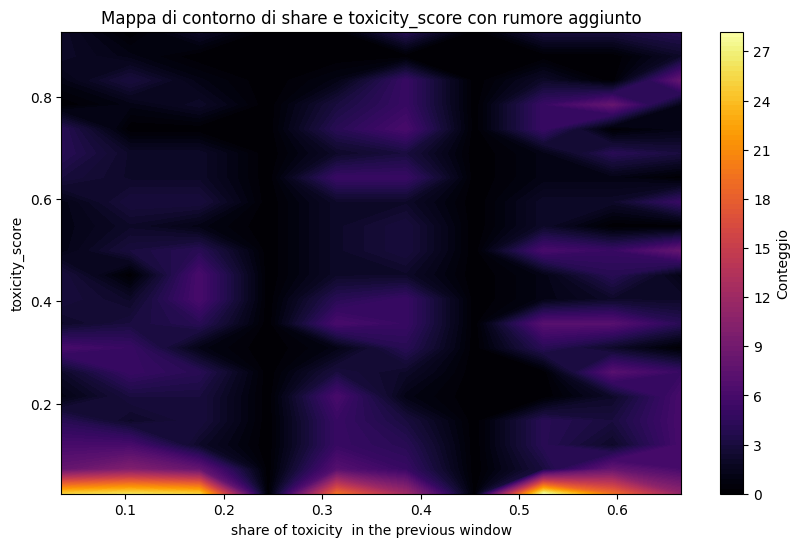

In [133]:
import numpy as np
import matplotlib.pyplot as plt

# Supponiamo che balanced_df sia il DataFrame bilanciato

# Creiamo i dati per la griglia con rumore aggiunto a x
np.random.seed(42)  # Per la riproducibilità
x = balanced_df['share']
y =( balanced_df['toxicity_score'])

# Definiamo la griglia con granularità diversa per x e y
x_bins = 10
y_bins = 20

# Creiamo la griglia dei dati
H, xedges, yedges = np.histogram2d(x, y, bins=[x_bins, y_bins])

# Creiamo i punti centrali dei bin per x e y
x_centers = (xedges[:-1] + xedges[1:]) / 2
y_centers = (yedges[:-1] + yedges[1:]) / 2

# Creiamo la figura
plt.figure(figsize=(10, 6))

# Creiamo il grafico con linee di livello
plt.contourf(x_centers, y_centers, H.T, cmap='inferno', levels=100)

# Aggiungiamo la barra colore
plt.colorbar(label='Conteggio')

# Impostiamo il titolo e le etichette degli assi
plt.title('Mappa di contorno di share e toxicity_score con rumore aggiunto')
plt.xlabel('share of toxicity  in the previous window')
plt.ylabel('toxicity_score')

# Mostriamo il grafico
plt.show()


## Infiammabilità degli utenti

Data un interazione, utente post, composta da piu commenti come evolve la tossicità nel tempo. Incrementa o è stabile o sdecresce?

Possiamo dire sia user invariant questa dinamica?

In [89]:
data['is_toxic']=data['toxicity_score']>0.6

sorted_data = data.sort_values(by=['user','post_id', 'created_at'], ascending=True)
sorted_data['toxicity_score_diff'] = sorted_data['toxicity_score'].diff()
sorted_data=sorted_data.dropna(subset='toxicity_score_diff')

user_stats = sorted_data.groupby('user').agg(
    mean_toxicity_score_diff=('toxicity_score_diff', 'mean'),
    mean_is_toxic=('is_toxic', 'mean'),number_of_comments=('comment_id', 'count')
).reset_index()

user_stats=user_stats[user_stats['number_of_comments']>5]

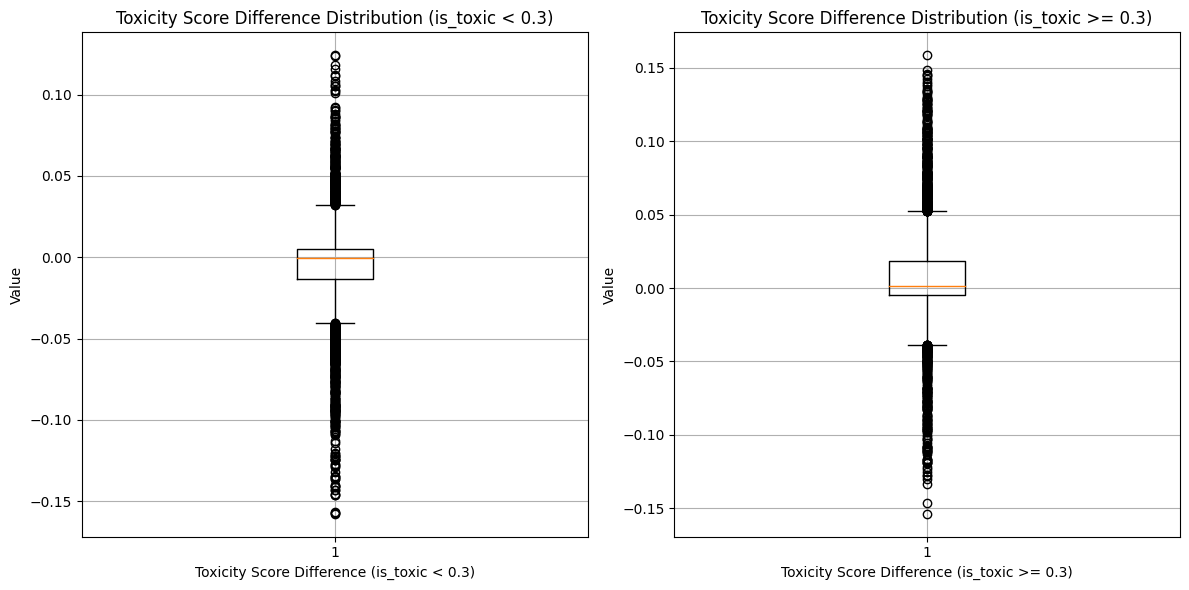

In [97]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming user_stats is the DataFrame obtained from previous code

# Filter data based on is_toxic values
is_toxic_low = user_stats[user_stats['mean_is_toxic'] < 0.15]
is_toxic_high = user_stats[user_stats['mean_is_toxic'] >= 0.15]

# Create boxplots
plt.figure(figsize=(12, 6))

# Boxplot for is_toxic < 0.3
plt.subplot(1, 2, 1)
plt.boxplot(is_toxic_low['mean_toxicity_score_diff'])
plt.xlabel('Toxicity Score Difference (is_toxic < 0.3)')
plt.ylabel('Value')
plt.title('Toxicity Score Difference Distribution (is_toxic < 0.3)')
plt.grid(True)

# Boxplot for is_toxic >= 0.3
plt.subplot(1, 2, 2)
plt.boxplot(is_toxic_high['mean_toxicity_score_diff'])
plt.xlabel('Toxicity Score Difference (is_toxic >= 0.3)')
plt.ylabel('Value')
plt.title('Toxicity Score Difference Distribution (is_toxic >= 0.3)')
plt.grid(True)

# Adjust layout and display
plt.tight_layout()
plt.show()


In [73]:
import pandas as pd
from scipy.stats import ttest_ind

# Assuming user_stats is the DataFrame obtained from previous code

# Filter data based on is_toxic
is_toxic_low = user_stats[user_stats['mean_is_toxic'] < 0.05]['mean_toxicity_score_diff']
is_toxic_high = user_stats[user_stats['mean_is_toxic'] >= 0.05]['mean_toxicity_score_diff']

# Perform t-test
tstat, pval = ttest_ind(is_toxic_low, is_toxic_high)

# Interpret results
print("T-statistic:", tstat)
print("p-value:", pval)

# Define significance level (alpha)
alpha = 0.05

# Check for significance
if pval < alpha:
    print("The difference in mean_toxicity_score_diff between is_toxic groups is statistically significant (p <", alpha, ").")
else:
    print("The difference in mean_toxicity_score_diff between is_toxic groups is not statistically significant (p >=", alpha, ").")


7        0.016898
14      -0.013867
15       0.016498
18       0.000954
30       0.000480
           ...   
36404   -0.041686
36413    0.005702
36415    0.000928
36417    0.001060
36418   -0.004443
Name: mean_toxicity_score_diff, Length: 4139, dtype: float64

## BUR

In [ ]:
df=data.copy()

# Filtro dei messaggi tossici, supponendo che un toxicity_score > threshold indica tossicità
threshold = 0.5
df_toxic = df[df['toxicity_score'] > threshold].copy()

# Convertiamo 'created_at' in formato datetime
df_toxic['created_at'] = pd.to_datetime(df_toxic['created_at'])

# Funzione per verificare se un thread ha una finestra di 30 minuti con almeno 20 commenti tossici
def has_toxic_window(df_thread):
    # Ordina per 'created_at'
    df_thread = df_thread.sort_values(by='created_at')
    for i in range(len(df_thread)):
        # Definisce l'inizio e la fine della finestra di 30 minuti
        start_time = df_thread.iloc[i]['created_at']
        end_time = start_time + pd.Timedelta(minutes=5)
        # Conta i commenti tossici nella finestra
        toxic_count = df_thread[(df_thread['created_at'] >= start_time) & (df_thread['created_at'] <= end_time)].shape[0]
        # Verifica se il conteggio è almeno 20
        if toxic_count >= 3:
            return True
    return False

# Applica la funzione a ciascun thread e filtra i thread che soddisfano la condizione
toxic_threads = []
for group_name, group_data in tqdm(df_toxic.groupby('post_id')):
    if has_toxic_window(group_data):
        toxic_threads.append(group_data)

toxic_threads = pd.concat(toxic_threads)

# Mostra i risultati
print(toxic_threads['post_id'].unique())

100%|██████████| 5283/5283 [01:19<00:00, 66.75it/s]


[  98144  173430  176425 ... 3579673 3580703 3580841]


Numero di valori NaN nel gruppo tossico: 0.5720962137144494
Numero di valori NaN nel gruppo non tossico: 0.5740749136344265


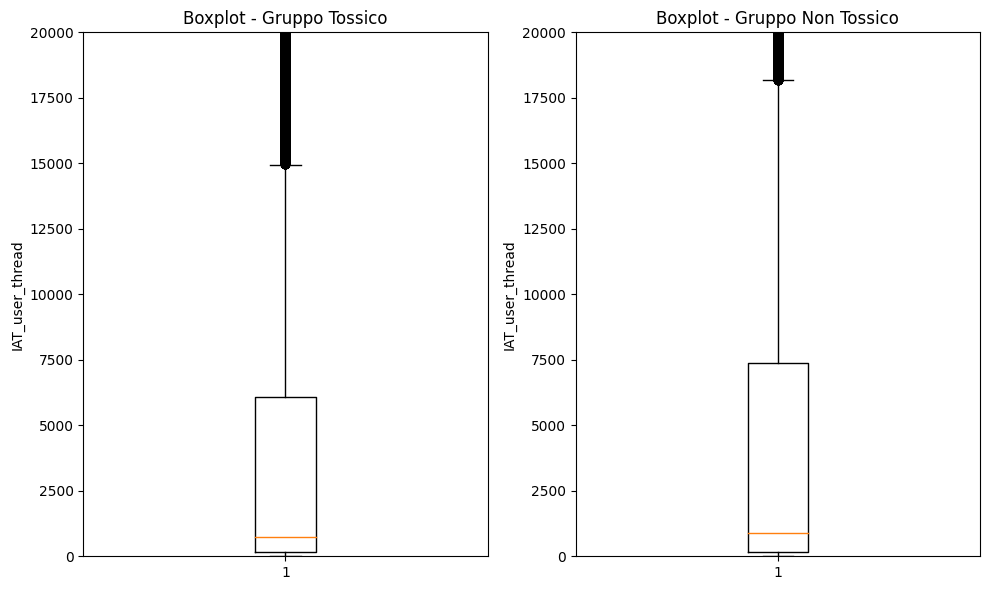

1650

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assicurati di avere correttamente importato il tuo DataFrame e di avere le colonne corrette
# Supponiamo che il DataFrame sia chiamato 'data' e le colonne 'post_id' e 'IAT_user_thread' esistano

# Seleziona solo i post_id tossici
toxic_post_ids = toxic_threads['post_id'].unique()

# Estrai i dati relativi agli IAT_user_thread per i post tossici
toxic_data = data[data['post_id'].isin(toxic_post_ids)]['IAT_user_thread']

# Estrai i dati relativi agli IAT_user_thread per i post non tossici
non_toxic_data = data[data['post_id'].isin(data['post_id'].sample(len(toxic_post_ids)))]['IAT_user_thread']

# Conta i valori NaN nei due gruppi
toxic_nan_count = toxic_data.isna().mean()
non_toxic_nan_count = non_toxic_data.isna().mean()

print("Numero di valori NaN nel gruppo tossico:", toxic_nan_count)
print("Numero di valori NaN nel gruppo non tossico:", non_toxic_nan_count)

# Crea i boxplot
plt.figure(figsize=(10, 6))

# Boxplot per il gruppo tossico
plt.subplot(1, 2, 1)
plt.boxplot(toxic_data.dropna(),showfliers=True)
plt.title('Boxplot - Gruppo Tossico')
plt.ylabel('IAT_user_thread')
plt.ylim(0,20000)

# Boxplot per il gruppo non tossico
plt.subplot(1, 2, 2)
plt.boxplot(non_toxic_data.dropna(),showfliers=True)
plt.title('Boxplot - Gruppo Non Tossico')
plt.ylabel('IAT_user_thread')
plt.ylim(0,20000)
plt.tight_layout()
plt.show()

len(toxic_post_ids)

In [ ]:
import scipy.stats as stats

# Rimuovi i valori NaN prima di eseguire il test
clean_toxic_data = toxic_data.dropna()
clean_non_toxic_data = non_toxic_data.dropna()

# Esegui il test t di Student
t_statistic, p_value = stats.ttest_ind(clean_toxic_data, clean_non_toxic_data)

# Stampa i risultati
print("Statistiche t:", t_statistic)
print("Valore p:", p_value)

# Confronta il valore p con un livello di significatività scelto (ad esempio 0.05)
alpha = 0.05
if p_value < alpha:
    print("La differenza tra i due gruppi è statisticamente significativa.")
else:
    print("La differenza tra i due gruppi non è statisticamente significativa.")


Statistiche t: -7.491624161781138
Valore p: 6.856778058026697e-14
La differenza tra i due gruppi è statisticamente significativa.


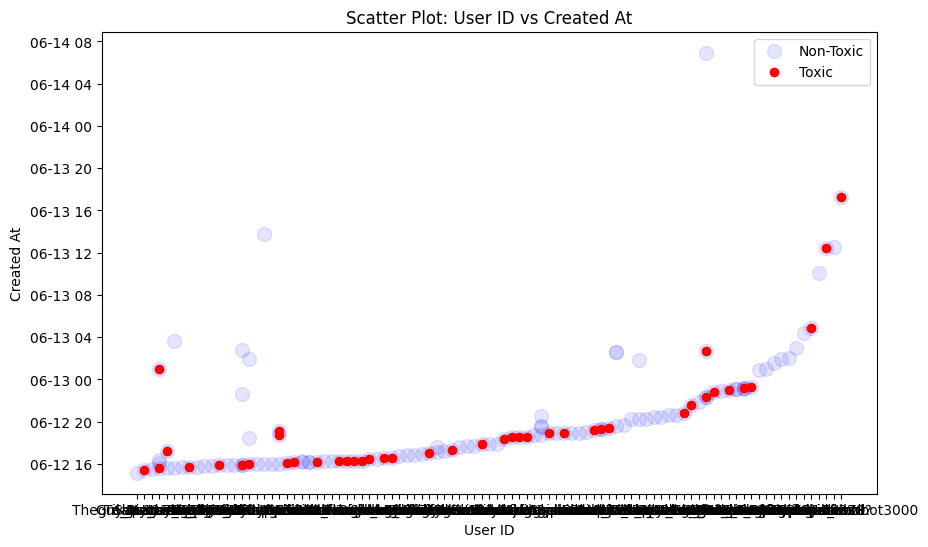

In [ ]:
thread=data[data['post_id']==3488343].sort_values(by='created_at')
thread=data[data['post_id']==3273720].sort_values(by='created_at')
thread['created_at'] = pd.to_datetime(thread['created_at'])
thread=thread.sort_values(by='created_at')
import matplotlib.pyplot as plt
import pandas as pd

# Assicurati di avere correttamente importato il tuo DataFrame e di avere le colonne corrette
# Supponiamo che il DataFrame sia chiamato 'thread' e le colonne 'user_id', 'toxicity_score' e 'created_at' esistano

# Seleziona solo i punti con tossicità maggiore di 0.6
toxic_thread = thread[thread['toxicity_score'] > 0.6]

# Crea lo scatter plot
plt.figure(figsize=(10, 6))

# Plot dei punti tossici


# Plot dei punti non tossici
plt.scatter(thread['user'], thread['created_at'], c='blue', label='Non-Toxic', alpha=0.1,s=100)
plt.scatter(toxic_thread['user'], toxic_thread['created_at'], c='red', label='Toxic')

plt.xlabel('User ID')
plt.ylabel('Created At')
plt.title('Scatter Plot: User ID vs Created At')
plt.legend()
plt.show()


In [ ]:
thread.text.iloc[0]
thread.toxicity_score.iloc[0]
thread.text.iloc[5]
thread.text.iloc[-1]
thread.toxicity_score.iloc[-1]
thread.created_at.iloc[-1]
thread.created_at.iloc[-1]

0.2028889

# 2 Ricostruisco i dialoghi tra utenti

data un interazione di un utente *i* in una conversazione *c*, chi sono gli utenti che la stimolano?

In [ ]:
from datetime import datetime
from tqdm import tqdm
from collections import Counter


def find_dialogue_users(data, user_id, thread_id):
    # Extract the thread
    thread = data[data['post_id'] == thread_id].copy()
    thread['created_at'] = pd.to_datetime(thread['created_at'])
    # Add user ID in a progressive way
    user_ids = pd.factorize(thread['user'])[0]
    thread.loc[:, 'ID'] = user_ids

    # Select comments of the user i
    interaction = thread[thread['user'] == user_id].reset_index()
    adjusted_interaction =  max(3, (len(interaction)-1))


    # Select users that are in dialogue with user i
    users_in_intervals = {}

    for i, comment in interaction.iterrows():
        if i == 0:
            Ti = pd.Timestamp(comment['created_at'])
            continue

        Tf = pd.Timestamp(comment['created_at'])
        thread_among_i_f = thread[(thread['created_at'] <= Tf) & (thread['created_at'] > Ti)]
        Ti = pd.Timestamp(comment['created_at'])
        users_in_intervals[i] = set(thread_among_i_f.user)


    # Inizializza un contatore per tenere traccia di quante volte ogni elemento appare negli insiemi
    element_counter = Counter()

    # Itera attraverso gli insiemi nel dizionario
    for interval_set in users_in_intervals.values():
        # Aggiungi gli elementi dell'insieme al contatore
        element_counter.update(interval_set)

    # Filtra gli elementi che sono presenti in almeno 3 su 4 insiemi
    utenti_dialogo = {elemento for elemento, count in element_counter.items() if count >= adjusted_interaction}
    utenti_dialogo.add(user_id)

    return utenti_dialogo



<ipython-input-95-fb7d017c938b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread.loc[:, 'ID'] = user_ids
<ipython-input-95-fb7d017c938b>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dialogo['colore']=dialogo['user']==user_id


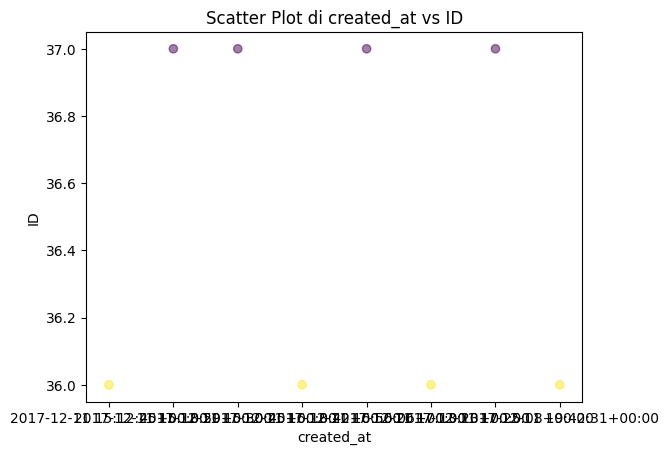

In [ ]:
user_id='Rotteuxx'
thread_id=2284542



utenti_dialogo=find_dialogue_users(data, user_id, thread_id)
thread=data[data['post_id']==thread_id]
user_ids = pd.factorize(thread['user'])[0]
thread.loc[:, 'ID'] = user_ids
dialogo = thread[thread['user'].isin(utenti_dialogo)]

dialogo['colore']=dialogo['user']==user_id

created_at = dialogo['created_at']
ID = dialogo['ID']
ID.unique()

# Aggiungi il colore nello scatter plot
plt.scatter(created_at, ID, c=dialogo['colore'], cmap='viridis', alpha=0.5)  # Imposta alpha a 0.5 per trasparenza
plt.xlabel('created_at')
plt.ylabel('ID')
plt.title('Scatter Plot di created_at vs ID')
plt.show()

analizza tutti i thread, e estrai le interazioni (user-thread) coinvolte nel dialogo

In [ ]:

utenti=[]
utenti_con_dialogo=[]
toxicità_commenti=[]
threads=[]
for thread_id in tqdm(data['post_id'].sample(3000)):
  thread=data[(data['post_id']==thread_id)]
  thread_interactions=thread.groupby(['user','post_id'])['comment_id'].count().reset_index()
  for i,row in (thread_interactions.iterrows()):#,total=len(thread_interactions)):
    utenti_dialogo = find_dialogue_users(data, row['user'],thread_id )
    utenti.append(row['user'])
    utenti_con_dialogo.append(len(utenti_dialogo))
    toxicità_commenti.append(np.median(thread[thread['user']==row['user']]['toxicity_score']))
    threads.append(thread_id)

df = pd.DataFrame({
    'utenti': utenti,
    'utenti_con_dialogo': utenti_con_dialogo,
    'toxicità_commenti': toxicità_commenti,
    'threads':threads
})


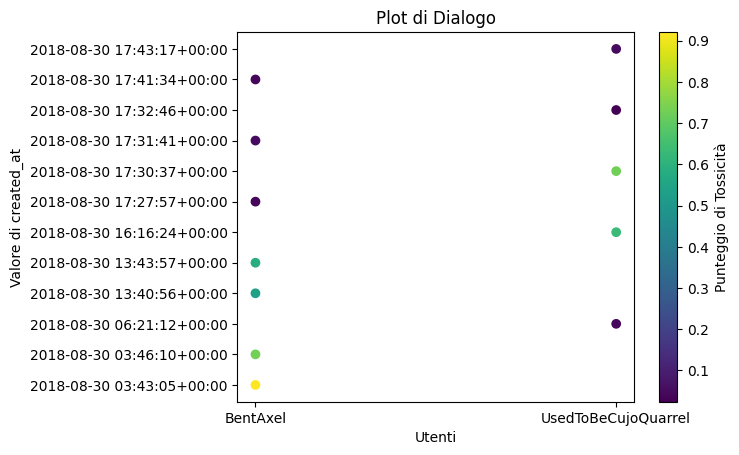

In [ ]:
interazioni_dialoganti=df[df['utenti_con_dialogo']>1][['utenti','threads']]

selected_dialogues = []

for i, row in tqdm(interazioni_dialoganti.iterrows(), total=len(interazioni_dialoganti)):
    user_id = row['utenti']
    thread_id = row['threads']
    utenti_dialogo = find_dialogue_users(data, user_id, thread_id)
    thread = data[data['post_id'] == thread_id]
    user_ids = pd.factorize(thread['user'])[0]
    thread.loc[:, 'ID'] = user_ids
    dialogo = thread[thread['user'].isin(utenti_dialogo)]
    dialogo['is_toxic'] = dialogo['toxicity_score'] > 0.6
    if (np.mean(dialogo.groupby('user')['is_toxic'].sum() > 1) == 1) & (dialogo.groupby('user')['comment_id'].count().max() - dialogo.groupby('user')['comment_id'].count().min() <= 2):

        selected_dialogues.append(dialogo)

len(selected_dialogues)
dialogo=selected_dialogues[7]
plt.scatter(dialogo['user'], dialogo['created_at'], c=dialogo['toxicity_score'], cmap='viridis')
plt.xlabel('Utenti')
plt.ylabel('Valore di created_at')
plt.title('Plot di Dialogo')
plt.colorbar(label='Punteggio di Tossicità')
plt.show()

#dialogo[['user','toxicity_score','text','created_at']]

da sistemare, in un thread quelli che dialogano sono meso aggregssivi di quelli che appaiono rando?

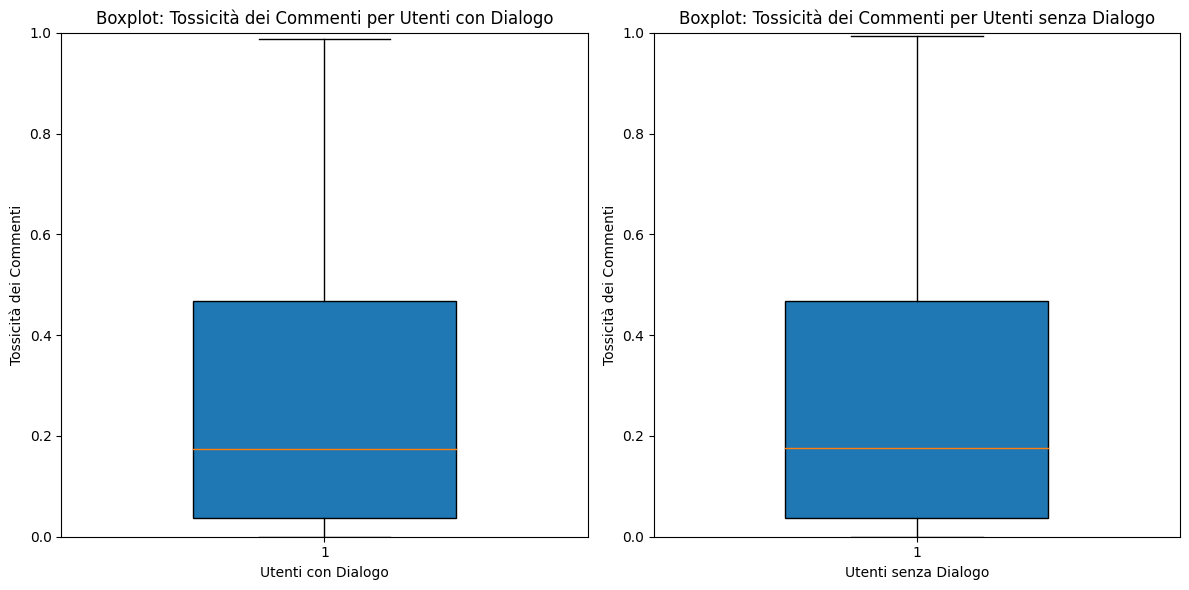

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Supponiamo che 'df' e 'thread' siano i DataFrame che hai già definito.

# Filtriamo gli utenti che dialogano e quelli che non dialogano
utenti_che_dialogano = df[df['utenti_con_dialogo'] != 0][['utenti','threads']]
utenti_che_non_dialogano = df[df['utenti_con_dialogo'] == 0][['utenti','threads']]





utenti_che_dialogano.rename(columns={'utenti': 'user', 'threads': 'post_id'}, inplace=True)
utenti_che_non_dialogano.rename(columns={'utenti': 'user', 'threads': 'post_id'}, inplace=True)

data_filtro_dialoganti = data.merge(utenti_che_dialogano, on=['user', 'post_id'], how='inner')
data_filtro_non_dialoganti = data.merge(utenti_che_non_dialogano, on=['user', 'post_id'], how='inner')

# Filtra le righe in `data` che hanno gli stessi user e post_id degli utenti che dialogano
data_filtro_dialoganti = data.merge(utenti_che_dialogano, on=['user', 'post_id'], how='inner')
data_filtro_non_dialoganti = data.merge(utenti_che_non_dialogano, on=['user', 'post_id'], how='inner')




# Creazione dei boxplot
plt.figure(figsize=(12, 6))

# Boxplot per utenti che dialogano
plt.subplot(1, 2, 1)
plt.boxplot(data_filtro_dialoganti['toxicity_score'], vert=True, widths=0.5, patch_artist=True)
plt.title('Boxplot: Tossicità dei Commenti per Utenti con Dialogo')
plt.xlabel('Utenti con Dialogo')
plt.ylim(0,1)
plt.ylabel('Tossicità dei Commenti')

# Boxplot per utenti che non dialogano
plt.subplot(1, 2, 2)
plt.boxplot(data_filtro_non_dialoganti['toxicity_score'], vert=True, widths=0.5, patch_artist=True)
plt.ylim(0,1)
plt.title('Boxplot: Tossicità dei Commenti per Utenti senza Dialogo')
plt.xlabel('Utenti senza Dialogo')
plt.ylabel('Tossicità dei Commenti')

plt.tight_layout()
plt.show()


In termini di tossictà non sembra esserci alcuna differenza tra i messaggi scambiati da interazioni che avvengono in modo coordinator ispetto a un altro utente, ovvero dialoghi, e interazioni indipendenti .

{('1Sorry_SOB', 1853667),
 ('1Sorry_SOB', 3505303),
 ('1scm', 3506024),
 ('22jam22', 2160030),
 ('22jam22', 2268819),
 ('6double5321', 407922),
 ('963189_137', 3416642),
 ('AUSAFVet', 2831177),
 ('AUSAFVet', 3280421),
 ('Adrinus', 367767),
 ('Alabaster_Jones', 342638),
 ('AlphaWookie', 1506897),
 ('Amadameus', 1906235),
 ('AmaleksHairyAss', 1988934),
 ('Apathy', 1848874),
 ('ArcAngel', 2954449),
 ('BONFIRE_OF_VANITIES', 3294413),
 ('Bfwilley', 3069182),
 ('BigCheeze', 855123),
 ('Blacksmith21', 2512897),
 ('Blacksmith21', 3294413),
 ('BlowjaySimpson', 3498716),
 ('Bonscottrocks007', 2853547),
 ('Broc_Lia', 2694125),
 ('Broc_Lia', 3498716),
 ('CHOOCHOOMF', 1988934),
 ('Candygram_for_Mongo', 1696232),
 ('Cat-hax', 3498716),
 ('Cheesebooger', 2006678),
 ('Cheesebooger', 2160030),
 ('ChiCom', 2991633),
 ('Chimaira92', 2694125),
 ('CovfefeFan', 3065107),
 ('Cracklord', 3043530),
 ('Cristo316', 3072161),
 ('Crpowell821', 3065107),
 ('CrudOMatic', 3546015),
 ('CrustyBeaver52', 2991633),
 ('Cu

quali sono gli utenti piu presenti in questi set

In [ ]:
from collections import Counter

# Inizializza un contatore per tenere traccia di quante volte ogni elemento appare negli insiemi
element_counter = Counter()

# Itera attraverso gli insiemi nel dizionario
for interval_set in users_in_intervals.values():
    # Aggiungi gli elementi dell'insieme al contatore
    element_counter.update(interval_set)

# Filtra gli elementi che sono presenti in almeno 3 su 4 insiemi
utenti_dialogo = {elemento for elemento, count in element_counter.items() if count >=1}
utenti_dialogo.add(user_id)

{'16tons', 'Gringojones', 'Tallest_Skil', 'boredTech'}

::

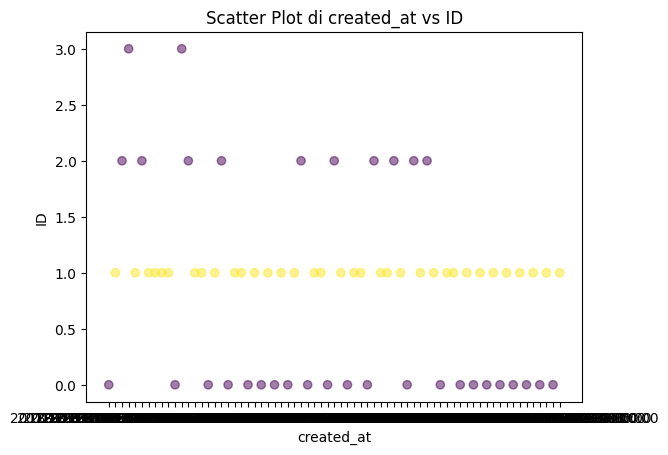

In [ ]:
utenti_dialogo.add(user_id)
dialogo = thread[thread['user'].isin(utenti_dialogo)]

dialogo['colore']=dialogo['user']==user_id

created_at = dialogo['created_at']
ID = dialogo['ID']


# Aggiungi il colore nello scatter plot
plt.scatter(created_at, ID, c=dialogo['colore'], cmap='viridis', alpha=0.5)  # Imposta alpha a 0.5 per trasparenza
plt.xlabel('created_at')
plt.ylabel('ID')
plt.title('Scatter Plot di created_at vs ID')
plt.show()


## 1.2 La dilatazione finale smussa la tossicità

*Osserviamo come se la fase finale della conversazione risulta piu rilassata, con ritmi piu flebili, la conversazione tende ad essere meno tossica.*


<ipython-input-168-ef8206485fc2>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='IAT_increases', y='is_toxic', data=merged_df,showfliers=True, palette='Set1')


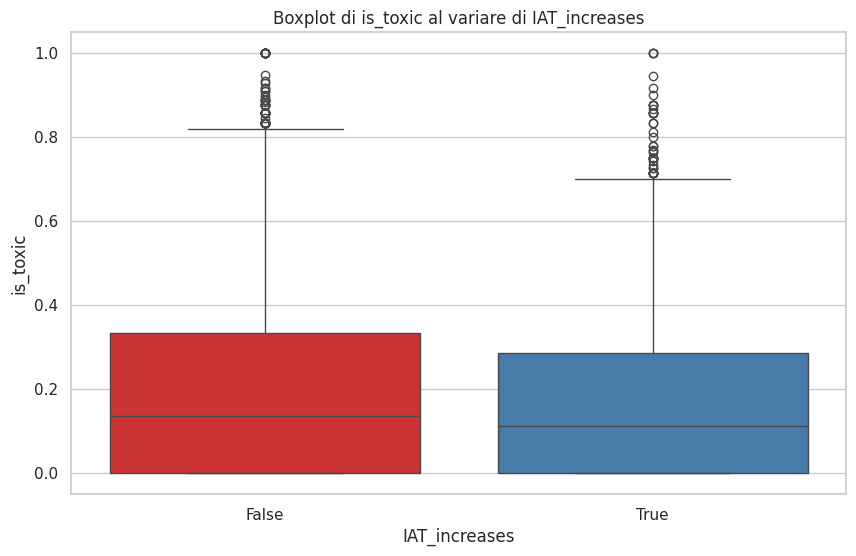

Test t di Student:
Statistiche t: 2.8280866870376293
Valore p: 0.004694994072955063


In [ ]:
# Trova l'IAT mediana e finale di ogni conversazione per ogni utente
mean_IAT = data.groupby(['user', 'root_submission'])['IAT_user_thread'].median().reset_index()
final_IAT = data[data['position_class'].isin([number_of_classes-1])].groupby(['user', 'root_submission'])['IAT_user_thread'].first().reset_index()
semifinal_IAT = data[data['position_class'].isin([number_of_classes-2])].groupby(['user', 'root_submission'])['IAT_user_thread'].first().reset_index()

merged_df = mean_IAT.merge(final_IAT, on=['user', 'root_submission'], suffixes=('_median', '_final'))
merged_df = merged_df.merge(semifinal_IAT, on=['user', 'root_submission'], suffixes=('', '_semifinal'))

merged_df['IAT_increases'] = (merged_df['IAT_user_thread_final'] > 1.5*(merged_df['IAT_user_thread_median'])) & ( merged_df['IAT_user_thread'] > 1.2*(merged_df['IAT_user_thread_median']))


data['is_toxic']=data['toxicity_score']>0.6
toxicity=data.groupby(['user','root_submission'])['is_toxic'].mean()

merged_df=merged_df.merge(toxicity,on=['user', 'root_submission'])

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.boxplot(x='IAT_increases', y='is_toxic', data=merged_df,showfliers=True, palette='Set1')
plt.title('Boxplot di is_toxic al variare di IAT_increases')
plt.xlabel('IAT_increases')
plt.ylabel('is_toxic')
plt.show()

means = merged_df.groupby('IAT_increases')['is_toxic'].mean()
t_statistic, p_value = stats.ttest_ind(merged_df.loc[merged_df['IAT_increases'] == 0, 'is_toxic'],
                                       merged_df.loc[merged_df['IAT_increases'] == 1, 'is_toxic'])

print("Test t di Student:")
print("Statistiche t:", t_statistic)
print("Valore p:", p_value)

## 1.3 Ritmo della conversazione e ritmo dell'utente

Se l'inter return time dell'utente segue il flusso della conversazione tende ad essere piu tossico, mentre se dilatato nel tempo tende a esserlo meno.

<ipython-input-425-93f0650c34ce>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_toxic']=df['toxicity_score']>0.6


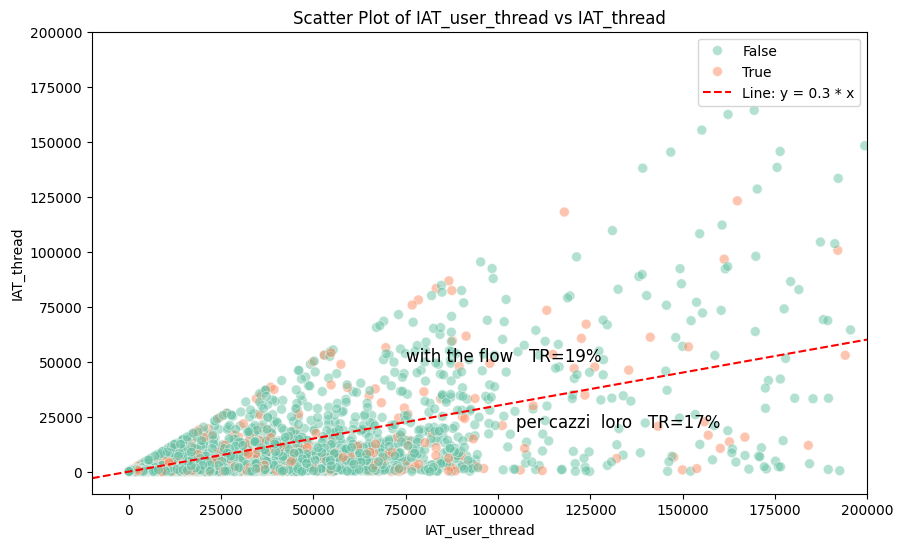

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Assuming 'data' is your DataFrame
df = data.dropna(subset=['IAT_user_thread', 'IAT_thread'])
df['is_toxic']=df['toxicity_score']>0.6


import seaborn as sns
import matplotlib.pyplot as plt

# Plot the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='IAT_user_thread', y='IAT_thread', hue='is_toxic', data=df, s=50, alpha=0.5, palette='Set2')
plt.title('Scatter Plot of IAT_user_thread vs IAT_thread')
plt.xlabel('IAT_user_thread')
plt.ylabel('IAT_thread')
plt.xlim(-10000, 200000)
plt.ylim(-10000, 200000)
plt.legend(title='Is Toxic')

# Plot the line
x_values = np.linspace(-10000, 200000, 100)
y_values = 0.3 * x_values
plt.plot(x_values, y_values, color='red', linestyle='--', label='Line: y = 0.3 * x')
plt.text(75000, 50000, 'with the flow   TR=19%', fontsize=12, color='black')
plt.text(105000, 20000, 'per cazzi  loro   TR=17%', fontsize=12, color='black')

plt.legend()

plt.show()




<ipython-input-413-604c798975ff>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['with_the_flow']=(df['IAT_thread']/(df['IAT_user_thread']+0.00000001))>0.3


il dataset è diviso in 0.537639405204461


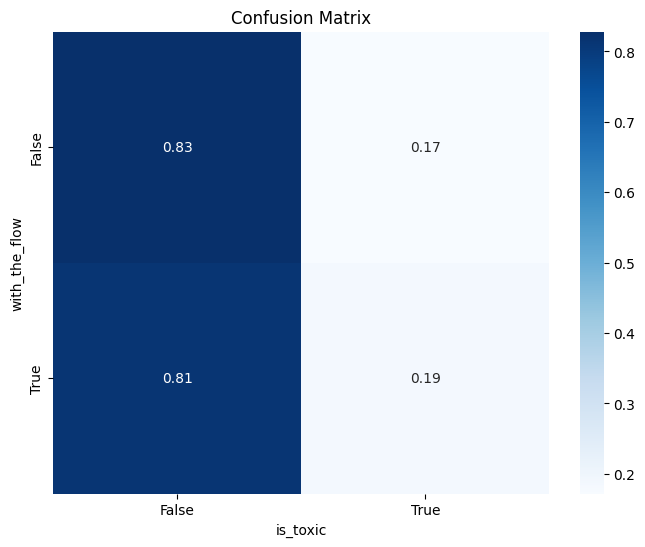


Chi-square Test - Chi2: 4.942654165069275, p-value: 0.026201772280128145


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df['with_the_flow']=(df['IAT_thread']/(df['IAT_user_thread']+0.00000001))>0.3

print('il dataset è diviso in', (df['with_the_flow'].mean()))
conf_matrix = confusion_matrix(df['with_the_flow'], df['is_toxic'])
conf_df = pd.DataFrame(conf_matrix)
conf_matrix_norm = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

conf_df_norm = pd.DataFrame(conf_matrix_norm,index=['False', 'True'], columns=['False', 'True'])
plt.figure(figsize=(8, 6))
sns.heatmap(conf_df_norm, annot=True, fmt='.2f', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('with_the_flow')
plt.xlabel('is_toxic')
plt.show()
chi2, p, _, _ = chi2_contingency(conf_matrix)
print(f"\nChi-square Test - Chi2: {chi2}, p-value: {p}")


## 2 La tossicità, quanto la conversazione si dilata

come abbiamo visto, molto spesso le fasi finali di una interazione, sono caratterizzate da tempo di risposta dilatati. Questo ha un lieve impatto sulla tossicità.

Dobbiamo controllare:

1.   Quanto la varianza degli IAT impatta la tossicità.
2.   Estrarre da una interazione tutti gli utenti che con l'utente in analisi.



In [ ]:
data['post_id']=data['root_submission']
filtered_data = data[data['sequential_number_of_comment_by_user_in_thread'] == 2]

# Group by 'user' and 'post_id' and get the max of 'IAT_user_thread'
max_iat = filtered_data.groupby(['user', 'post_id'])['IAT_user_thread'].max().reset_index()

# Rename the column to match the desired output
max_iat.rename(columns={'IAT_user_thread': 'IAT_user_thread_2'}, inplace=True)

# Merge the result with the original DataFrame on 'user' and 'post_id'
result = pd.merge(data, max_iat, on=['user', 'post_id'], how='left')

result['change_IAT']=(result['IAT_user_thread']-result['IAT_user_thread_2'])/result['IAT_user_thread_2']
data=result

Correlazione tra varianza di IAT_user_thread e media di is_toxic: -0.005897508140422825


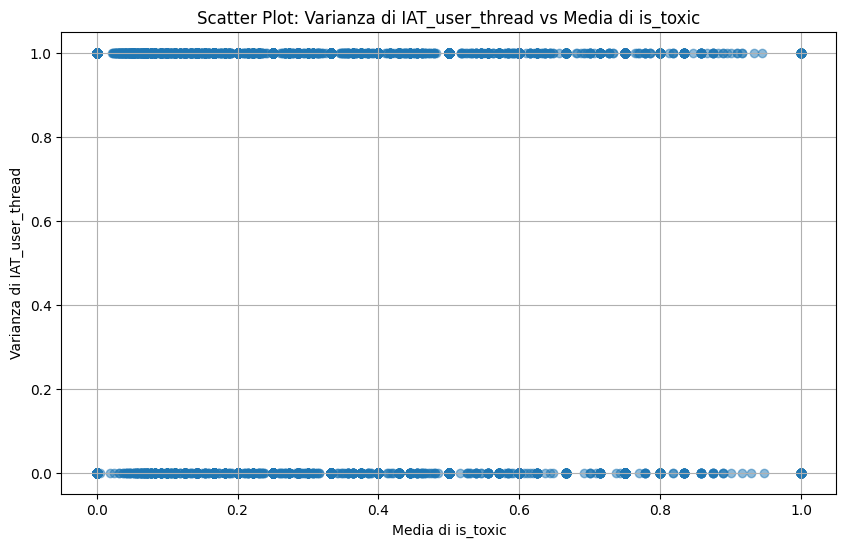

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data['is_toxic']=data['toxicity_score']>0.6
df=data[data['number_of_comments_by_user_in_thread']>3]
# Calcola la varianza di 'IAT_user_thread' per 'post_id' e 'user'
varianza_IAT_interaction = df.groupby(['post_id', 'user'])['change_IAT'].max().reset_index()
varianza_IAT_interaction['change_IAT']=varianza_IAT_interaction['change_IAT']>varianza_IAT_interaction['change_IAT'].median()
# Calcola la media di 'is_toxic' per 'post_id' e 'user'
mean_toxicity_interaction = df.groupby(['post_id', 'user'])['is_toxic'].mean().reset_index()

# Unisci i due dataframe sulla base di 'post_id' e 'user'
merged_df = pd.merge(varianza_IAT_interaction, mean_toxicity_interaction, on=['post_id', 'user'])

# Rinominare le colonne per chiarezza
merged_df.columns = ['post_id', 'user', 'VariatioonIAT', 'mean_toxicity']
merged_df['VariatioonIAT']=(merged_df['VariatioonIAT'])
# Calcola la correlazione tra varianza e media
correlation = merged_df['VariatioonIAT'].corr(merged_df['mean_toxicity'])
print(f"Correlazione tra varianza di IAT_user_thread e media di is_toxic: {correlation}")

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(merged_df['mean_toxicity'], merged_df['VariatioonIAT'], alpha=0.5)
plt.title('Scatter Plot: Varianza di IAT_user_thread vs Media di is_toxic')
plt.xlabel('Media di is_toxic')
plt.ylabel('Varianza di IAT_user_thread')
plt.grid(True)
plt.show()



<Figure size 1000x600 with 0 Axes>

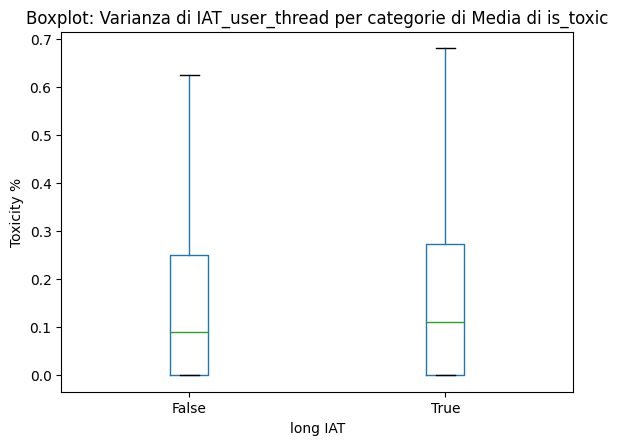

In [ ]:
plt.figure(figsize=(10, 6))
merged_df.boxplot(column='mean_toxicity', by='VariatioonIAT', grid=False,showfliers=False)
plt.title('Boxplot: Varianza di IAT_user_thread per categorie di Media di is_toxic')
plt.suptitle('')  # Rimuove il titolo automatico aggiunto da pandas
plt.xlabel('long IAT')
plt.ylabel('Toxicity %')
plt.show()

## 2 Tossicità

## 2.1 Velocità e Tossicità

Preso un utente in una conversazione, la tossicità non sembra velocizzare i suoi tempi di ritposta.

In [ ]:
data=data[data['number_of_comments_by_user_in_thread']>4].copy()
data['position_user_thread']=data['sequential_number_of_comment_by_user_in_thread']/data['number_of_comments_by_user_in_thread']

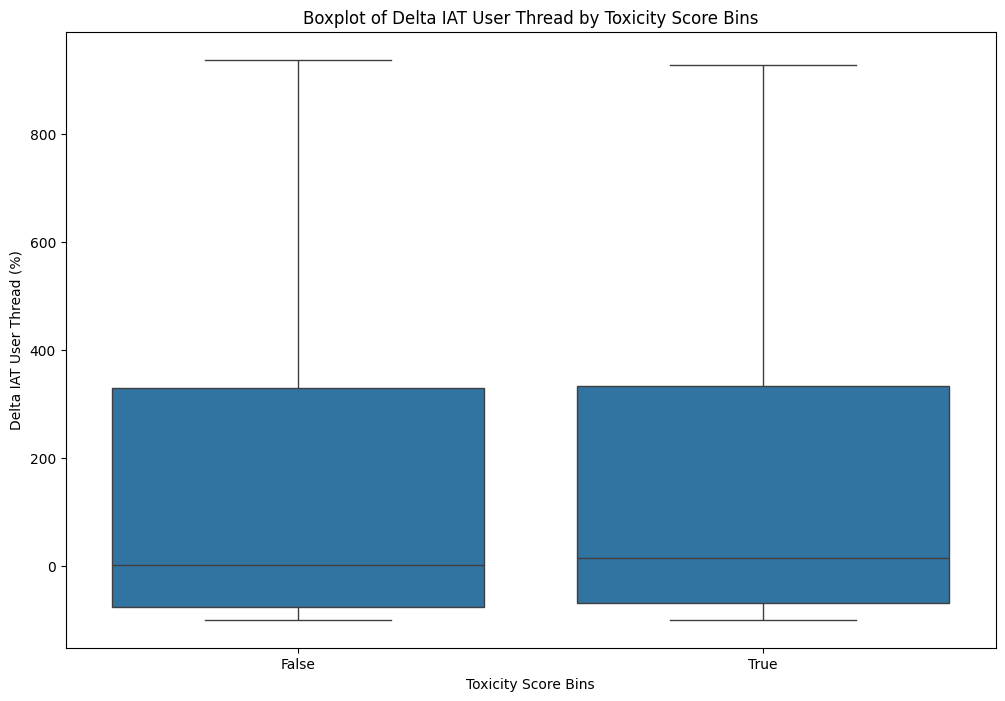

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Convertiamo la colonna 'created_at' in datetime per un ordinamento corretto
df['created_at'] = pd.to_datetime(df['created_at'])
df['is_toxic'] =df['toxicity_score']>0.6

# Ordiniamo il DataFrame
df_sorted = df.sort_values(by=['user', 'root_submission', 'created_at'])

# Calcola la variazione percentuale di IAT_user_thread tra la riga corrente e quella precedente
df_sorted['delta_IAT_user_thread'] = df_sorted['IAT_user_thread'].pct_change() * 100

# Filtriamo solo le colonne necessarie
df_filtered = df_sorted[['delta_IAT_user_thread', 'is_toxic', 'sequential_number_of_comment_by_user_in_thread']]

# Creiamo i boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(x='is_toxic', y='delta_IAT_user_thread', data=df_filtered,showfliers=False)
plt.xlabel('Toxicity Score Bins')
plt.ylabel('Delta IAT User Thread (%)')
plt.title('Boxplot of Delta IAT User Thread by Toxicity Score Bins')
plt.show()


## 2.2 Toxicità nell'intorno

Analizziamo se un commento tossico, nel suo intorno è circondato da commenti tossici. I seguenti risultati sono ottenuti usando un intorno di raggio 2. Mostrano che esiste una correlazione tra il livello di tossicità e l'intorno temporale di una conversazione.
Questo però non tiene conto che in alcune piattaforme le conversazioni si ramificano.

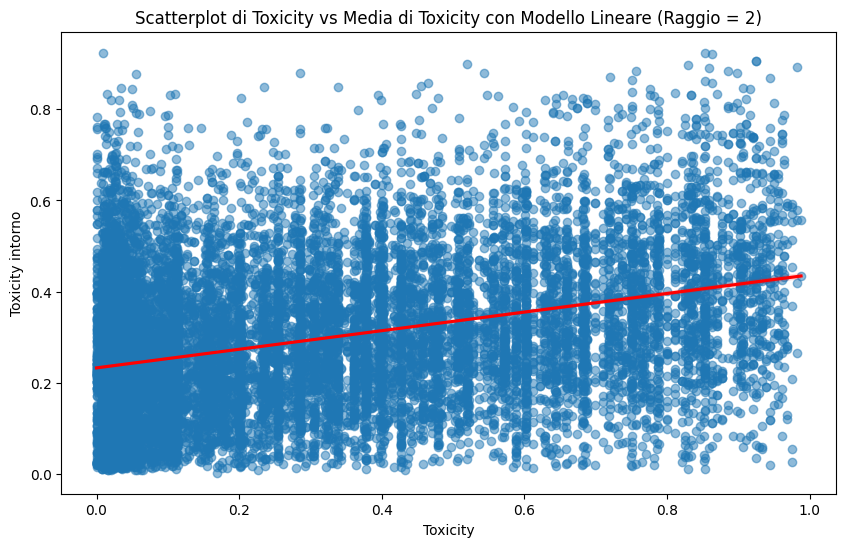

                            OLS Regression Results                            
Dep. Variable:       Toxicity intorno   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     1988.
Date:                Thu, 23 May 2024   Prob (F-statistic):               0.00
Time:                        13:51:58   Log-Likelihood:                 4377.6
No. Observations:               16140   AIC:                            -8751.
Df Residuals:                   16138   BIC:                            -8736.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2248      0.002    106.857      0.0

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from tqdm import tqdm

# Supponiamo che data_sorted sia già definito e ordinato

# Raggi da considerare
radii = [2, 3, 4, 5, 10,15,20]

# Lista per memorizzare tutti i risultati
all_results = []
model_summaries = {}

for r in radii:
    x = []
    y = []

    # Iterazione sul DataFrame data_sorted
    for i, row in tqdm(data_sorted.iterrows(), total=len(data_sorted)):
        tox = row['toxicity_score']
        created_at = row['created_at']

        df = data_sorted[data_sorted['root_submission'] == row['root_submission']].reset_index()

        idx = (df['created_at'] == created_at).idxmax()
        mean_tox = np.mean(df.loc[max(0, idx - r):min(len(df) - 1, idx + r), 'toxicity_score'].drop(idx))

        # Aggiungi i valori a x e y solo se non sono NaN o non numerici
        if pd.notna(mean_tox) and np.isfinite(mean_tox):
            x.append(tox)
            y.append(mean_tox)

    # Creazione del DataFrame per il raggio corrente e aggiunta della colonna Radius
    scatter_df = pd.DataFrame({'Toxicity': x, 'Toxicity intorno': y})
    scatter_df['Radius'] = r

    # Aggiunta del DataFrame alla lista di tutti i risultati
    all_results.append(scatter_df)

    # Creazione del modello di regressione lineare
    X = sm.add_constant(scatter_df['Toxicity'])
    model = sm.OLS(scatter_df['Toxicity intorno'], X).fit()
    model_summaries[r] = model.summary()

# Concatenazione di tutti i DataFrame in uno solo
final_results = pd.concat(all_results, ignore_index=True)

# Salvataggio del DataFrame finale su disco (opzionale)
final_results.to_csv('toxicity_results.csv', index=False)

# Visualizzazione del modello per il raggio 2
df = final_results[final_results['Radius'] == 10]
plt.figure(figsize=(10, 6))
sns.regplot(x='Toxicity', y='Toxicity intorno', data=df, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Scatterplot di Toxicity vs Media di Toxicity con Modello Lineare (Raggio = 2)')
plt.xlabel('Toxicity')
plt.ylabel('Toxicity intorno')
plt.show()

# Stampa del sommario del modello per il raggio 2
print(model_summaries[2])


## 3 Propagazione Tossicità

La tossicità si propagatra utenti che sono connessi temporalemnte?

## 3.1 Grafo

In [ ]:
import pandas as pd
from itertools import combinations
import pandas as pd
import networkx as nx
data['root_submission'].value_counts().reset_index()
data['created_at'] = pd.to_datetime(data['created_at'])

data = data.dropna(subset=['user'])

thread = data[data['root_submission'] == data['root_submission'].sample(1).values[0]]


users=thread.user.dropna().unique()

user_pairs = list(combinations(users, 2))

edge_weights = []

# Calcolo dei pesi per le coppie di utenti
for pair in tqdm(user_pairs):
    user1_dates = thread[thread['user'] == pair[0]]['created_at']
    user2_dates = thread[thread['user'] == pair[1]]['created_at']

    if not user1_dates.empty and not user2_dates.empty:
        distances_1_2 = [min(abs(date1 - date2).total_seconds() for date2 in user2_dates) for date1 in user1_dates]
        distances_2_1 = [min(abs(date2 - date1).total_seconds() for date1 in user1_dates) for date2 in user2_dates]
        distances=(np.max(distances_1_2)+np.max(distances_2_1))/2

        # Numero totale di messaggi scambiati tra i due utenti
        total_messages = len(user1_dates) + len(user2_dates) - 1

        # Calcolo del peso come funzione della vicinanza temporale e del numero di messaggi
        w = ((total_messages) ** 3) * (1 / distances if distances else 0)
        # Aggiunta dei pesi alla lista
        edge_weights.append((pair[0], pair[1], w))
        edge_weights.append((pair[1], pair[0], w))

edge_weights_df = pd.DataFrame(edge_weights, columns=['source', 'target', 'weight'])

print("DataFrame dei pesi degli archi:")
print(edge_weights_df)

100%|██████████| 210/210 [00:00<00:00, 601.24it/s]

DataFrame dei pesi degli archi:
                   source                target    weight
0              drakesdoom              Balrogic  0.042520
1                Balrogic            drakesdoom  0.042520
2              drakesdoom             edistojim  0.003289
3               edistojim            drakesdoom  0.003289
4              drakesdoom          Partoghimeos  0.042520
..                    ...                   ...       ...
415  olhyUXuPQJNRLGgQrhDQ              fry_hole  0.000106
416              fry_hole          confusedcrib  0.000357
417          confusedcrib              fry_hole  0.000357
418  olhyUXuPQJNRLGgQrhDQ          confusedcrib  0.031496
419          confusedcrib  olhyUXuPQJNRLGgQrhDQ  0.031496

[420 rows x 3 columns]


In [ ]:
# Create the graph
G = nx.Graph()
for _, row in edge_weights_df.iterrows():
    source = row['source']
    target = row['target']
    weight = row['weight']
    G.add_edge(source, target, weight=weight)



In [ ]:
# Add toxicity value to each user
max_toxicity_scores = thread.groupby(['user'])['toxicity_score'].max().reset_index()
max_toxicity_scores_dict = dict(zip(max_toxicity_scores['user'], max_toxicity_scores['toxicity_score']))
for node in G.nodes():
    if node in max_toxicity_scores_dict:
        G.nodes[node]['max_toxicity_score'] = max_toxicity_scores_dict[node]
    else:
        G.nodes[node]['max_toxicity_score'] = None

In [ ]:

# Prune Network
edge_weights = [weight for _, _, weight in G.edges(data='weight')]

weight_threshold = np.percentile(edge_weights, 80)

pruned_G = G.copy()
for edge in G.edges():
    source, target = edge
    weight = G.edges[edge]['weight']
    if weight < weight_threshold:
        pruned_G.remove_edge(source, target)

<ipython-input-139-3f7be2509b2c>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


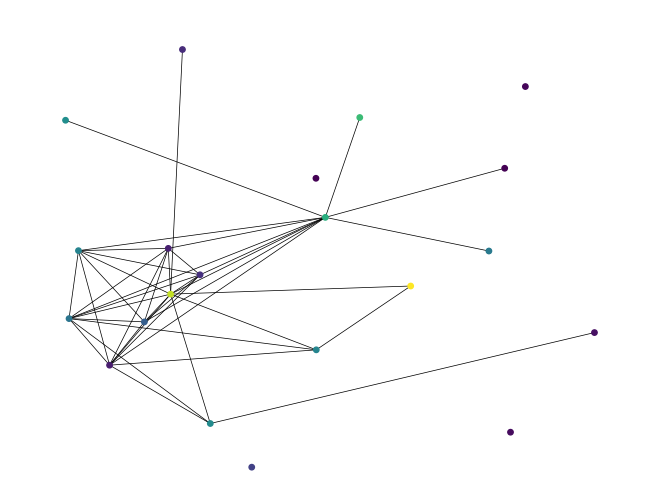

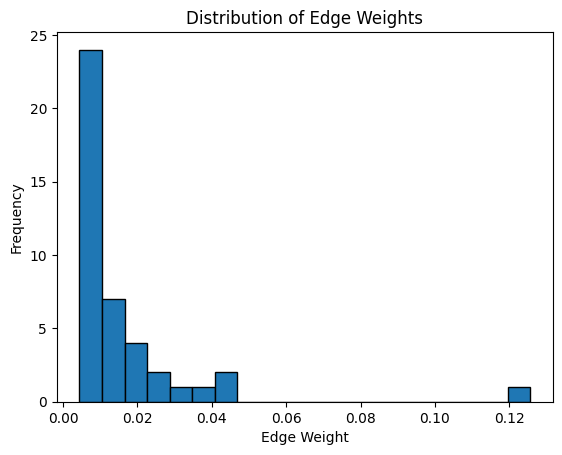

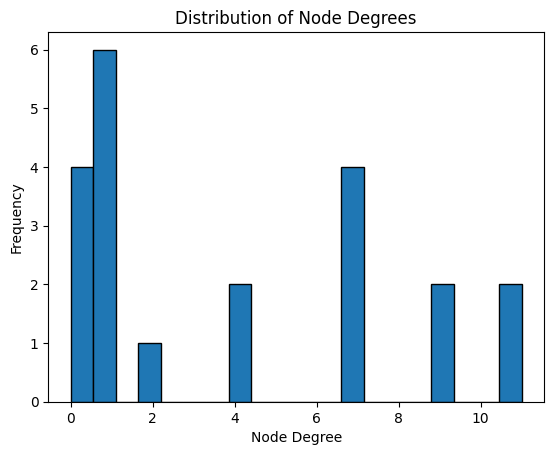

In [ ]:
# Visualize Graph
cmap = plt.cm.get_cmap('viridis')
max_toxicity_scores = [G.nodes[node]['max_toxicity_score'] for node in G.nodes()]
norm = plt.Normalize(vmin=min(max_toxicity_scores), vmax=max(max_toxicity_scores))
node_colors = [cmap(norm(score)) if score is not None else 'gray' for score in max_toxicity_scores]
nx.draw(pruned_G, with_labels=False, node_size=15, width=0.52, node_color=node_colors)
plt.show()

# Distribution of edge weights
edge_weights = [pruned_G.edges[edge]['weight'] for edge in pruned_G.edges()]
plt.hist(edge_weights, bins=20, edgecolor='black')
plt.xlabel('Edge Weight')
plt.ylabel('Frequency')
plt.title('Distribution of Edge Weights')
plt.show()

# Distribution of node degrees
node_degrees = [degree for _, degree in pruned_G.degree()]
plt.hist(node_degrees, bins=20, edgecolor='black')
plt.xlabel('Node Degree')
plt.ylabel('Frequency')
plt.title('Distribution of Node Degrees')
plt.show()



In [ ]:
max_weight_edge = max(pruned_G.edges(data=True), key=lambda x: x[2]['weight'])

print("L'arco più forte è:", max_weight_edge)

L'arco più forte è: ('Drakinor', 'Phoenix_MD', {'weight': 0.1256913021618904})


<ipython-input-141-df6ff3298acf>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['created_at'] = pd.to_datetime(df['created_at'])


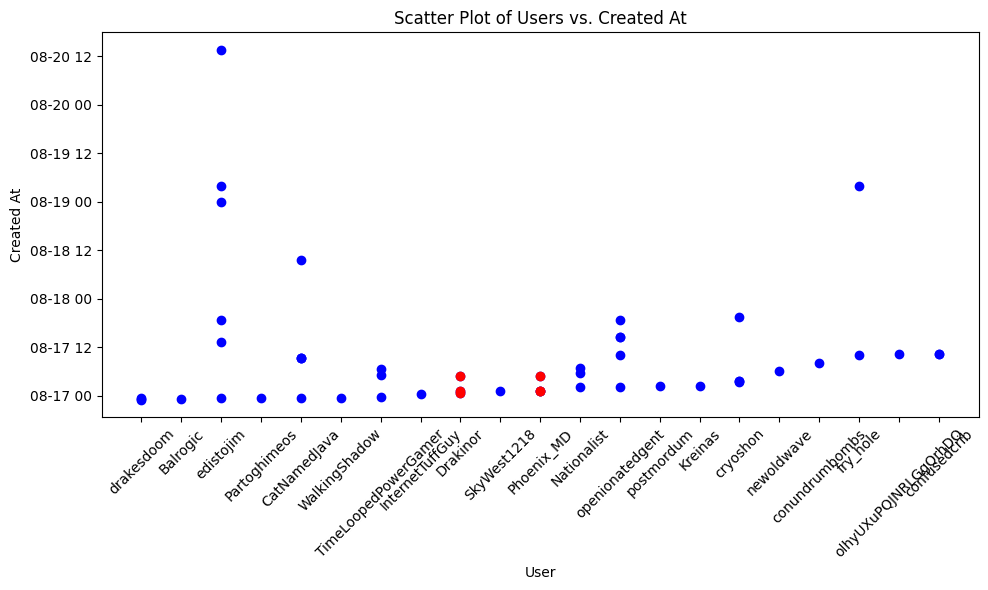

In [ ]:
# Convertire la colonna 'created_at' in datetime

df=thread[(thread['user']==max_weight_edge[0]) | (thread['user']==max_weight_edge[1])]

df['created_at'] = pd.to_datetime(df['created_at'])
# Creare il plot
plt.figure(figsize=(10, 6))
plt.scatter(thread['user'], thread['created_at'], c='blue', marker='o')
plt.scatter(df['user'], df['created_at'], c='red', marker='o')

# Aggiungere etichette e titolo
plt.xlabel('User')
plt.ylabel('Created At')
plt.title('Scatter Plot of Users vs. Created At')

# Ruotare le etichette dell'asse X per una migliore leggibilità
plt.xticks(rotation=45)

# Mostrare il plot
plt.tight_layout()
plt.show()


In [ ]:
# Dato un utente, tossico o no, tra i suo amici c'è un tossico?
x_values=[]
y_values=[]

for node in pruned_G.nodes():
    max_toxicity_score = pruned_G.nodes[node]['max_toxicity_score']

    neighbors = list(pruned_G.neighbors(node))
    weights = [pruned_G[node][neighbor].get('weight', 1) for neighbor in pruned_G.neighbors(node)]
    normalized_weights = [(weight - min(weights)) / (max(weights) - min(weights)) if max(weights) != min(weights) else 1 for weight in weights] if weights else []


    if neighbors:
        toxicity_scores_neighbors = [pruned_G.nodes[neighbor].get('max_toxicity_score', 0) for neighbor in neighbors]
        numeric_list = [1 if value else 0 for value in toxicity_scores_neighbors]
        median_toxicity_score_neighbors = np.mean([a * b for a, b in zip(normalized_weights, toxicity_scores_neighbors)])
    else:
        median_toxicity_score_neighbors = 0

    x_values.append(max_toxicity_score)
    y_values.append(median_toxicity_score_neighbors)

df = pd.DataFrame({'x': x_values, 'y': y_values})
df=df.dropna()



In [ ]:

if isinstance(df['x'][0], bool):
    # Creiamo lo scatterplot
  plt.figure(figsize=(10, 6))
  plt.scatter(df['x'], df['y'])
  plt.title('Scatterplot di x e y')
  plt.xlabel('x')
  plt.ylabel('y')
  plt.show()
else:
  import pandas as pd
  import numpy as np
  import matplotlib.pyplot as plt
  from scipy.stats import ttest_ind

  # Supponiamo che il DataFrame df sia già caricato

  # Calcolare le medie dei valori di 'y' per i gruppi definiti da 'x'
  mean_tossico = np.mean(df[df['x']]['y'])
  mean_non_tossico = np.mean(df[~df['x']]['y'])

  print('tossico:', mean_tossico)
  print('non tossico:', mean_non_tossico)

  # Stampare i boxplot dei due gruppi
  plt.figure(figsize=(10, 6))
  df.boxplot(column='y', by='x', grid=False)
  plt.title('Boxplot di y per i gruppi tossico e non tossico')
  plt.suptitle('')  # Rimuove il titolo automatico generato da pandas
  plt.xlabel('x')
  plt.ylabel('y')
  plt.show()

  # Eseguire un test di indipendenza (t-test) tra i due gruppi
  group_tossico = df[df['x']]['y']
  group_non_tossico = df[~df['x']]['y']

  t_stat, p_value = ttest_ind(group_tossico, group_non_tossico)

  print('T-statistic:', t_stat)
  print('P-value:', p_value)


IndentationError: unexpected indent (<ipython-input-146-ad6a27c0828b>, line 2)

## 3.2 Procedure for all threads

In [ ]:
import pandas as pd
from itertools import combinations
import pandas as pd
import networkx as nx
import time
data['root_submission'].value_counts().reset_index()
data['created_at'] = pd.to_datetime(data['created_at'])
time_limit = 60

data = data.dropna(subset=['user'])
dataframes = []
for i in tqdm(range(1000)):
  start_time = time.time()
  thread = data[data['root_submission'] == data['root_submission'].sample(1).values[0]]


  users=thread.user.dropna().unique()

  user_pairs = list(combinations(users, 2))

  edge_weights = []

  # Calcolo dei pesi per le coppie di utenti
  for pair in (user_pairs):
      end_time = time.time()  # End timing the iteration
      if end_time - start_time > time_limit:  # Check if the iteration took longer than the time limit
          print(f"Iteration {i} took longer than {time_limit} seconds. Skipping to next iteration.")
          break
      user1_dates = thread[thread['user'] == pair[0]]['created_at']
      user2_dates = thread[thread['user'] == pair[1]]['created_at']

      if not user1_dates.empty and not user2_dates.empty:
          distances_1_2 = [min(abs(date1 - date2).total_seconds() for date2 in user2_dates) for date1 in user1_dates]
          distances_2_1 = [min(abs(date2 - date1).total_seconds() for date1 in user1_dates) for date2 in user2_dates]
          distances=(np.max(distances_1_2)+np.max(distances_2_1))/2

          total_messages = len(user1_dates) + len(user2_dates) - 1

          w = ((total_messages) ** 3) * (1 / distances if distances else 0)

          edge_weights.append((pair[0], pair[1], w))
          edge_weights.append((pair[1], pair[0], w))

  edge_weights_df = pd.DataFrame(edge_weights, columns=['source', 'target', 'weight'])

  # Create the graph
  G = nx.Graph()
  for _, row in edge_weights_df.iterrows():
      source = row['source']
      target = row['target']
      weight = row['weight']
      G.add_edge(source, target, weight=weight)


  # Add toxicity value to each user
  max_toxicity_scores = thread.groupby(['user'])['toxicity_score'].max().reset_index()
  max_toxicity_scores_dict = dict(zip(max_toxicity_scores['user'], max_toxicity_scores['toxicity_score']))
  for node in G.nodes():
      if node in max_toxicity_scores_dict:
          G.nodes[node]['max_toxicity_score'] = max_toxicity_scores_dict[node]
      else:
          G.nodes[node]['max_toxicity_score'] = 0
  # Prune Network
  edge_weights = [weight for _, _, weight in G.edges(data='weight')]

  weight_threshold = np.percentile(edge_weights, 95)

  pruned_G = G.copy()
  for edge in G.edges():
      source, target = edge
      weight = G.edges[edge]['weight']
      if weight < weight_threshold:
          pruned_G.remove_edge(source, target)
  # Dato un utente, tossico o no, tra i suo amici c'è un tossico?
  x_values=[]
  y_values=[]

  for node in pruned_G.nodes():
      max_toxicity_score = pruned_G.nodes[node]['max_toxicity_score']

      neighbors = list(pruned_G.neighbors(node))
      weights = [pruned_G[node][neighbor].get('weight', 1) for neighbor in pruned_G.neighbors(node)]
      normalized_weights = [(weight - min(weights)) / (max(weights) - min(weights)) if max(weights) != min(weights) else 1 for weight in weights] if weights else []


      if neighbors:
          toxicity_scores_neighbors = [pruned_G.nodes[neighbor].get('max_toxicity_score', 0) for neighbor in neighbors]
          numeric_list = [1 if value else 0 for value in toxicity_scores_neighbors]
          median_toxicity_score_neighbors = np.mean([a * b for a, b in zip(normalized_weights, toxicity_scores_neighbors)])
          median_toxicity_score_neighbors = np.max(toxicity_scores_neighbors)

      else:
          median_toxicity_score_neighbors = 0

      x_values.append(max_toxicity_score)
      y_values.append(median_toxicity_score_neighbors)

  df = pd.DataFrame({'x': x_values, 'y': y_values})
  dataframes.append(df)  # Aggiungi il DataFrame alla lista

  # Concatenazione di tutti i DataFrame nella lista
  final_df = pd.concat(dataframes, ignore_index=True)
  final_df.to_csv('/content/drive/MyDrive/thesis/data/x_y_toxicity_homopily.csv')

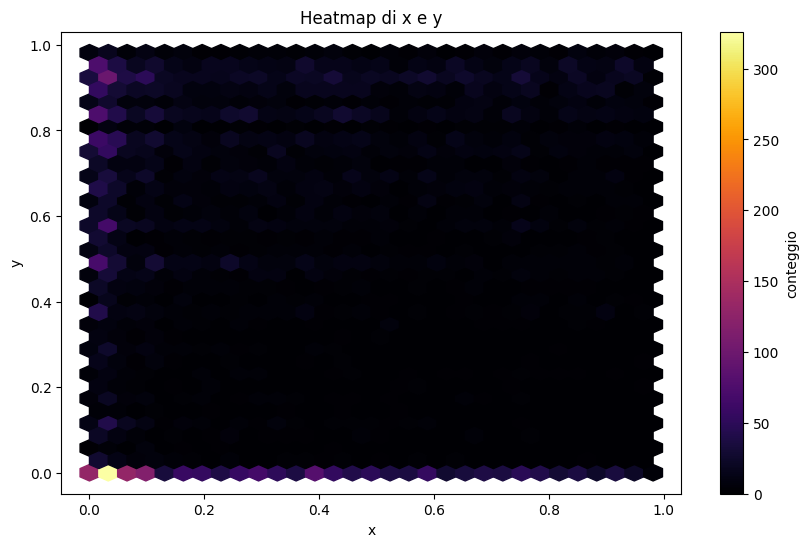

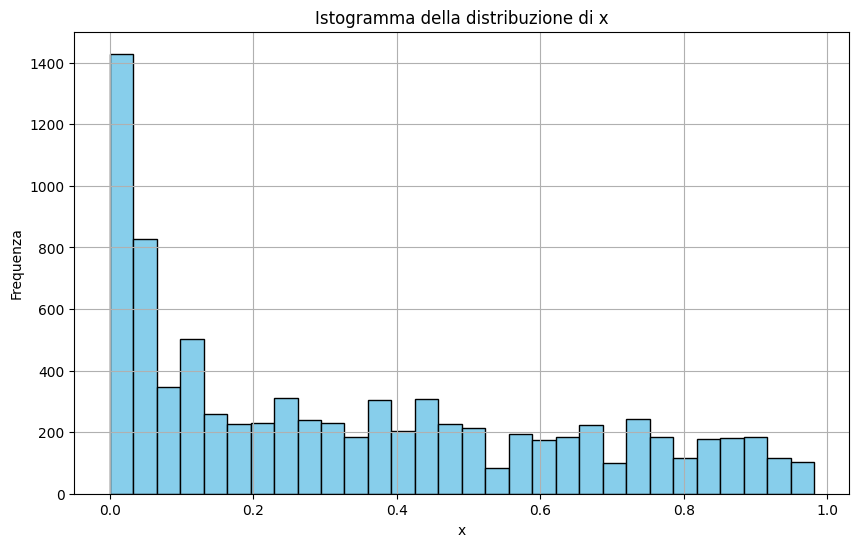

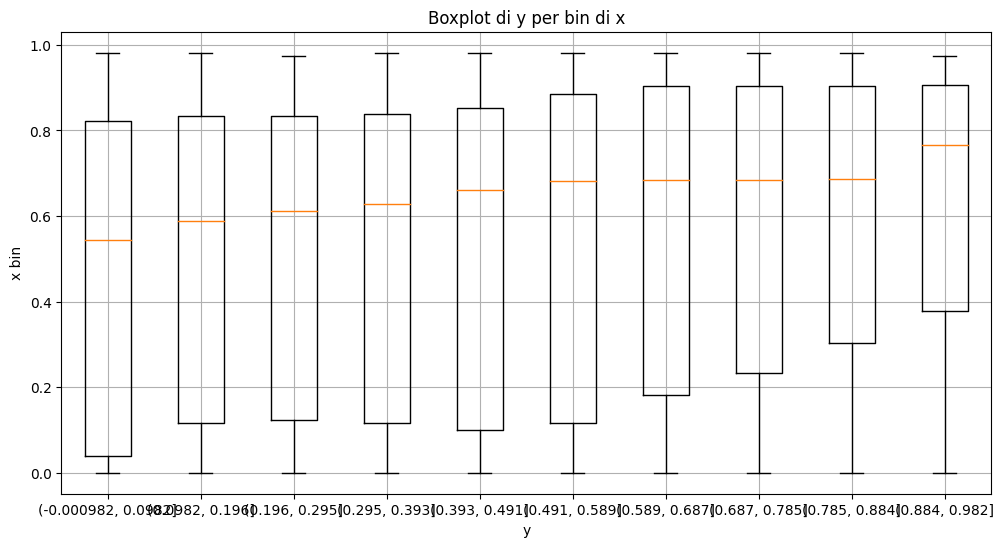

In [ ]:
df=final_df
plt.figure(figsize=(10, 6))
plt.hexbin(df['x'], df['y'], gridsize=30, cmap='inferno')
plt.colorbar(label='conteggio')
plt.title('Heatmap di x e y')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


import matplotlib.pyplot as plt

# Plot dell'istogramma della distribuzione di x
plt.figure(figsize=(10, 6))
plt.hist(df['x'], bins=30, color='skyblue', edgecolor='black')
plt.title('Istogramma della distribuzione di x')
plt.xlabel('x')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()



import pandas as pd
import matplotlib.pyplot as plt

# Suddividi x in 5 bin
df['x_bin'] = pd.cut(df['x'], bins=10)

# Creare boxplot per y in base ai bin di x
plt.figure(figsize=(12, 6))
plt.title('Boxplot di y per bin di x')
plt.xlabel('y')
plt.ylabel('x bin')
plt.grid(True)
plt.boxplot([df[df['x_bin'] == bin_val]['y'] for bin_val in sorted(df['x_bin'].unique())], vert=True, labels=sorted(df['x_bin'].unique()))
plt.show()




Chi-square test results:
Chi-square statistic: 3667.748063754232
p-value: 7.302201238195995e-05
Reject null hypothesis: There is evidence of dependence between x_bin and y.


## 4 Frequenza commento tossico

Con che frequenza arriva un messaggio tossico, questa dipende  dall'IAT dei messaggi, è omogenea nel tempoo?

In [ ]:
data['created_at'] = pd.to_datetime(data['created_at'])
thread = data[data['root_submission'] == data['root_submission'].sample(1).values[0]]


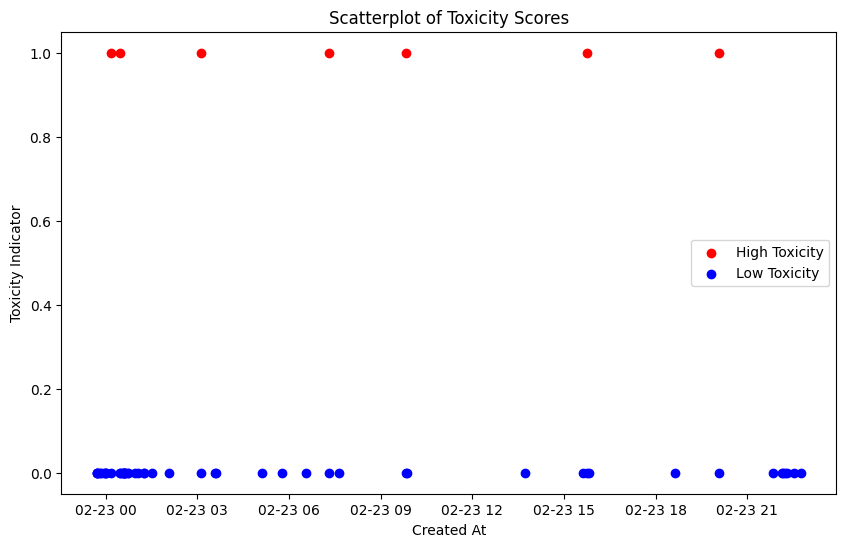

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Supponiamo che tu abbia già caricato il tuo DataFrame `thread`
# thread = pd.read_csv('path_to_your_data.csv')  # Carica i tuoi dati

# Filtra i dati basati sul punteggio di tossicità
high_toxicity = thread[thread['toxicity_score'] > 0.6]

# Crea lo scatterplot
plt.figure(figsize=(10, 6))

# Punti con alto punteggio di tossicità (1)
plt.scatter(high_toxicity['created_at'], [1] * len(high_toxicity), color='red', label='High Toxicity')

# Punti con basso punteggio di tossicità (0)
plt.scatter(thread['created_at'], [0] * len(thread), color='blue', label='Low Toxicity')

# Aggiungi etichette e titolo
plt.xlabel('Created At')
plt.ylabel('Toxicity Indicator')
plt.title('Scatterplot of Toxicity Scores')
plt.legend()

# Mostra il grafico
plt.show()


In [ ]:
import itertools

# Inizializza una lista vuota per contenere le somme cumulative
cumulative_sums = []

# Simula il tuo ciclo for con i dati di esempio
for i in range(10000):
    thread = data[data['root_submission'] == data['root_submission'].sample(1).values[0]]

    dfs_successors = thread['toxicity_score'] > 0.6

    count_falses = 0
    results = []
    for value in dfs_successors:
        if value:
            results.append(count_falses)
            count_falses = 0
        else:
            count_falses += 1
    results.append(count_falses)
    if len(dfs_successors) == sum(dfs_successors):
      results_divided = results
    else:
      results_divided = [result / (len(dfs_successors) - sum(dfs_successors)) for result in results]
    cumulative_sum = list(itertools.accumulate(results_divided))
    gol_per_intervallo = [0] *5
    if len(cumulative_sum)!=1:
      for istante in cumulative_sum:
          intervallo = int(istante * 5)-1
          gol_per_intervallo[intervallo]  +=( 1/len(cumulative_sum))


    # Aggiungi la somma cumulativa a cumulative_sums
    cumulative_sums.append(gol_per_intervallo)



[1.0, 1.0]

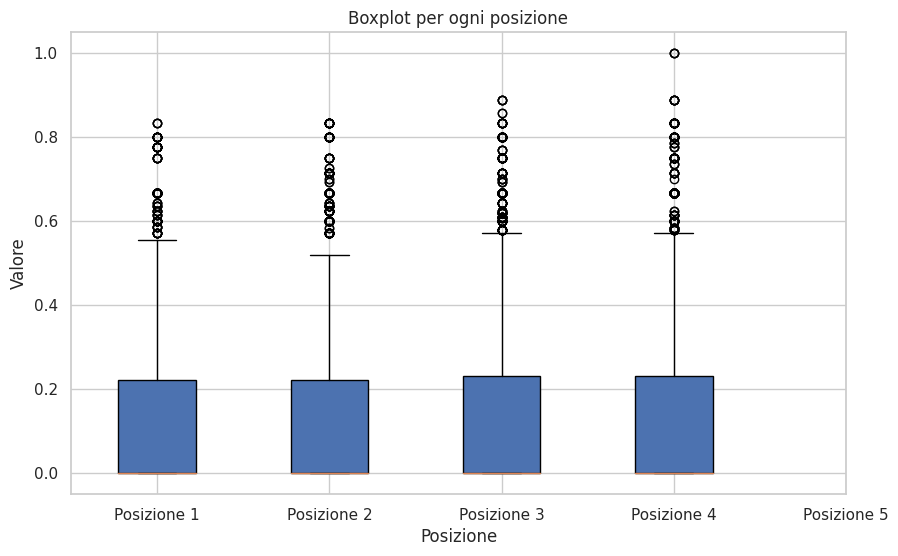

In [ ]:
# Creazione di una lista di liste per ogni posizione
valori_per_posizione = [[lista[i] for lista in cumulative_sums] for i in range(0,len(cumulative_sums[0])-1)]

# Creazione del boxplot per ogni posizione
plt.figure(figsize=(10, 6))
plt.boxplot(valori_per_posizione, patch_artist=True)
plt.xlabel('Posizione')
plt.ylabel('Valore')
plt.title('Boxplot per ogni posizione')
plt.xticks(range(1, len(cumulative_sums[0]) + 1), [f'Posizione {i + 1}' for i in range(len(cumulative_sums[0]))])
plt.grid(True)
plt.show()

## 5 Viaggio nel thread

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Supponiamo che 'data' sia il tuo DataFrame originale
df = data.copy()
df=df.dropna(subset='user').copy()
df['created_at'] = pd.to_datetime(df['created_at'])

results = []

for i in tqdm(range(100000)):
    row = df[df['sequential_number_of_comment_by_user_in_thread'] == 1].sample(1)

    thread = df[df['root_submission'] == row['root_submission'].values[0]]
    thread = thread.sort_values(by='created_at')

    entrance_index = list(thread['user'] == row['user'].values[0]).index(True)

    pre = thread.iloc[:entrance_index]

    x = np.mean(pre['sequential_number_of_comment_by_user_in_thread'] != 1)
    y = row['number_of_comments_by_user_in_thread'].values[0]>1
    k = row['upvotes'].values[0]
    z = len(pre) / row['number_of_comments'].values[0]

    results.append({'x': x, 'y': y, 'z': z, 'k':k})

# Crea un DataFrame dai risultati
results_df = pd.DataFrame(results)

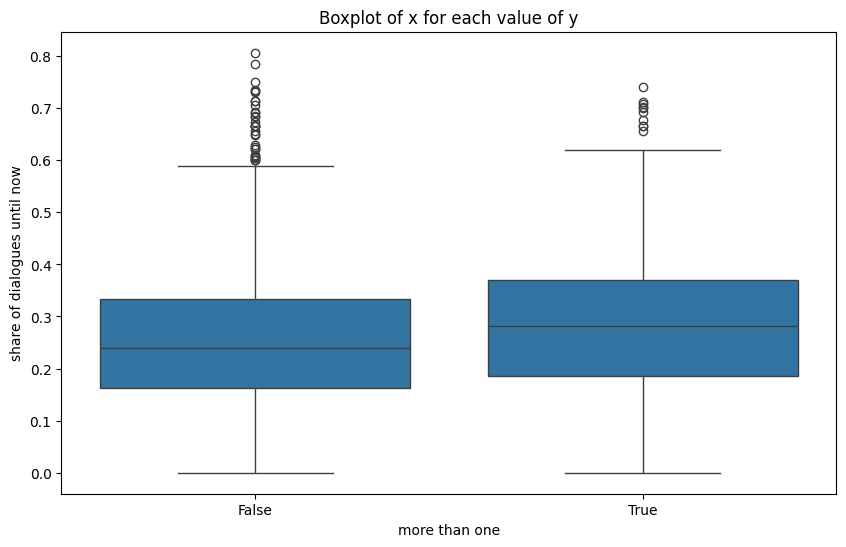

T-statistic: 5.578625408723046
P-value: 2.6477185221563615e-08
La differenza tra i gruppi è statisticamente significativa.


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Supponendo che tu abbia già creato il DataFrame results_df
# Filtra il DataFrame secondo le condizioni date
results_df_f = results_df[(results_df['z'] > 0.4) & (results_df['z'] < 0.6)]

# Visualizza i boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='y', y='x', data=results_df_f)
plt.title('Boxplot of x for each value of y')
plt.xlabel('more than one')
plt.ylabel('share of dialogues until now')
plt.show()

# Esegui il t-test per confrontare i valori di 'x' tra i due gruppi di 'y'
group1 = results_df_f[results_df_f['y'] == True]['x']
group2 = results_df_f[results_df_f['y'] == False]['x']

t_stat, p_value = ttest_ind(group1, group2)

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpreta il risultato
if p_value < 0.05:
    print("La differenza tra i gruppi è statisticamente significativa.")
else:
    print("La differenza tra i gruppi non è statisticamente significativa.")


<ipython-input-167-ef3f31ad63f9>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df_f['K_class'] = pd.cut(results_df_f['k'], bins=bins, include_lowest=True)


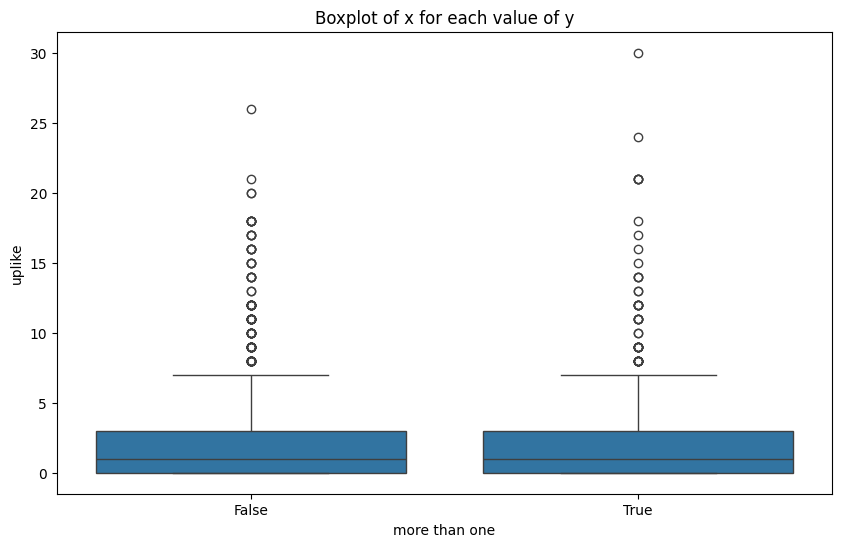

T-statistic: 2.8726163177530597
P-value: 0.00410045476783154
La differenza tra i gruppi è statisticamente significativa.


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Supponendo che tu abbia già creato il DataFrame results_df
# Filtra il DataFrame secondo le condizioni date
results_df_f = results_df[(results_df['z'] > 0.4) & (results_df['z'] < 0.6)]
bins = np.linspace(results_df_f['k'].min(), results_df_f['k'].max(), 6)

# Crea una nuova colonna 'K_class' con le classi di 'K'
results_df_f['K_class'] = pd.cut(results_df_f['k'], bins=bins, include_lowest=True)




# Visualizza i boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='y', y='k', data=results_df_f)
plt.title('Boxplot of x for each value of y')
plt.xlabel('more than one')
plt.ylabel('uplike')
plt.show()

# Esegui il t-test per confrontare i valori di 'x' tra i due gruppi di 'y'
group1 = results_df_f[results_df_f['y'] == True]['k']
group2 = results_df_f[results_df_f['y'] == False]['k']

t_stat, p_value = ttest_ind(group1, group2)

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpreta il risultato
if p_value < 0.05:
    print("La differenza tra i gruppi è statisticamente significativa.")
else:
    print("La differenza tra i gruppi non è statisticamente significativa.")


##  6 Partecipazione nel tempo

In [ ]:
import pandas as pd

long_root=data.groupby(['root_submission'])['comment_id'].count().reset_index()

long_root=long_root[long_root['comment_id']>long_root['comment_id'].quantile(0.5)]['root_submission'].unique()
df=data[data['root_submission'].isin(long_root)]

data_sorted = df.sort_values(by=['root_submission', 'created_at'])

# Aggiungi la colonna `_index_root` che indica la sequenza dei commenti nel thread
data_sorted['index_root'] = data_sorted.groupby('root_submission').cumcount() + 1

data_sorted['position_in_root']=data_sorted['index_root']/data_sorted['number_of_comments']
data_sorted['position_in_root'] = pd.cut(data_sorted['position_in_root'], bins=10)
grouped_data = data_sorted.groupby(['position_in_root', 'root_submission'])[['user', 'comment_id']].nunique().reset_index()
grouped_data['Parteciapation']=grouped_data['user']/grouped_data['comment_id']


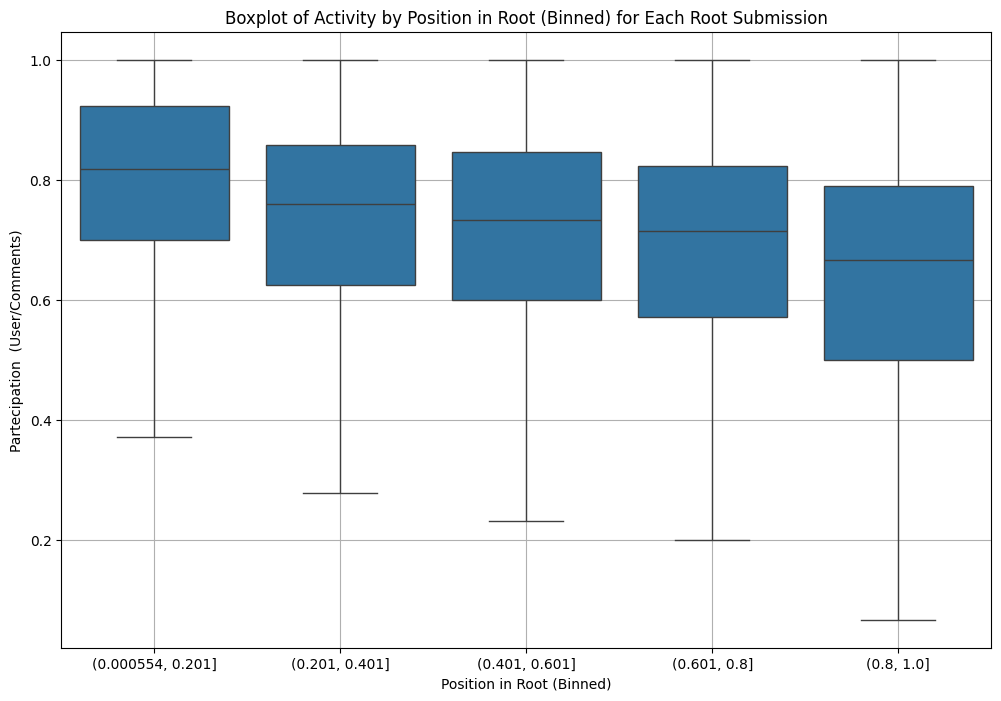

Results of ANOVA:
F-statistic: 240.9189900492654
p-value: 9.805921267622758e-200


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway


# Plot dei dati
plt.figure(figsize=(12, 8))

# Creare il boxplot con x diviso in 10 bin
sns.boxplot(data=grouped_data, x='position_in_root', y='Parteciapation', showfliers=False)

# Aggiungi etichette e titolo
plt.xlabel('Position in Root (Binned)')
plt.ylabel('Partecipation  (User/Comments)')
plt.title('Boxplot of Activity by Position in Root (Binned) for Each Root Submission')
plt.grid(True)

# Mostra il grafico
plt.show()

# Esegui un'analisi della varianza (ANOVA)
anova_results = f_oneway(*[grouped_data[grouped_data['position_in_root'] == bin_val]['Parteciapation'] for bin_val in grouped_data['position_in_root'].unique()])

# Stampare i risultati dell'ANOVA
print("Results of ANOVA:")
print("F-statistic:", anova_results.statistic)
print("p-value:", anova_results.pvalue)


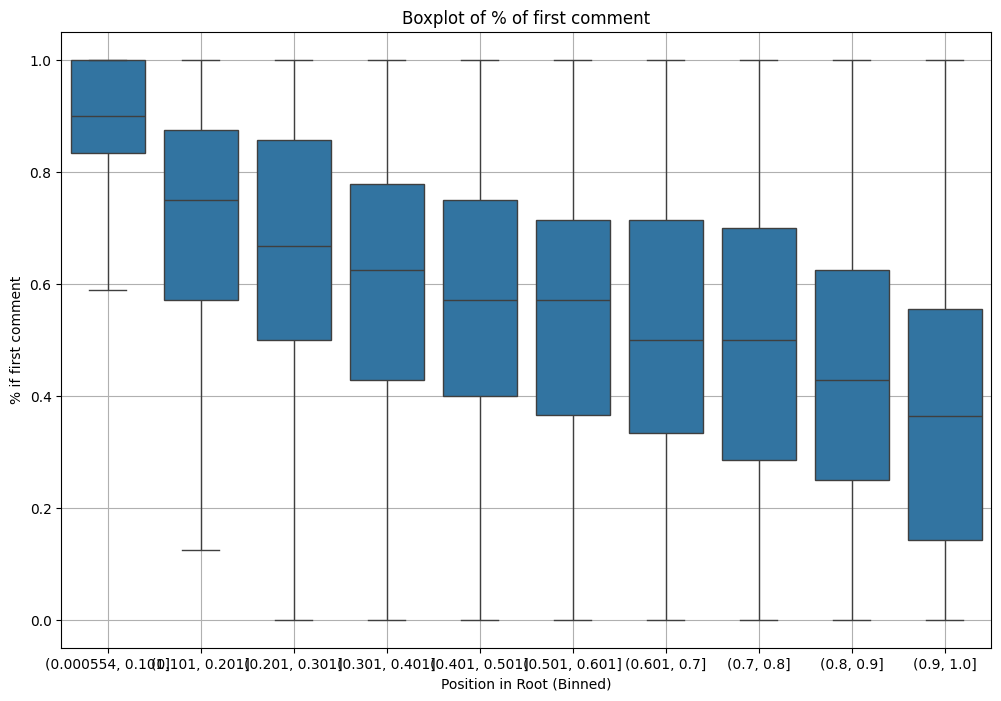

Results of ANOVA:
F-statistic: 938.4429925273153
p-value: 0.0


In [ ]:
# Conta quante osservazioni sono uguali a 1 per ciascun gruppo
data_sorted['first_comment']=data_sorted['sequential_number_of_comment_by_user_in_thread'] == 1


grouped_data=data_sorted.groupby(['root_submission','position_in_root'])['first_comment'].mean().reset_index()


# Plot dei dati
plt.figure(figsize=(12, 8))

# Creare il boxplot con x diviso in 10 bin
sns.boxplot(data=grouped_data, x='position_in_root', y='first_comment', showfliers=False)

# Aggiungi etichette e titolo
plt.xlabel('Position in Root (Binned)')
plt.ylabel('% if first comment')
plt.title('Boxplot of % of first comment')
plt.grid(True)

# Mostra il grafico
plt.show()

# Esegui un'analisi della varianza (ANOVA)
anova_results = f_oneway(*[grouped_data[grouped_data['position_in_root'] == bin_val]['first_comment'] for bin_val in grouped_data['position_in_root'].unique()])

# Stampare i risultati dell'ANOVA
print("Results of ANOVA:")
print("F-statistic:", anova_results.statistic)
print("p-value:", anova_results.pvalue)


## 7 Tossicità e densità di commenti

ci chiediamo se la posizione del commento in termini di densità dell'intorno intorno impatti la tossicità. Oltre a questo potremmo cercare sela densità di utenti influenza la cosa

Quello che posso fare per valutare quando la tossicità viene innescata da una conversazione tra utenti è


*   prenderee un interazione di un utente.
*   selezionare gli utenti che presentano commenti negli inttervalli Ci e Cj, in almeno due intervalli.
Vedere se per un numero superiore a due corrispondono livelli di tossicità piu altti.




In [ ]:
import pandas as pd
from tqdm import tqdm
from datetime import datetime, timedelta

# Inizializzo i vettori
shares_of_users = []
toxs = []

df = data[data['sequential_number_of_comment_by_user_in_thread']!=1]
data.columns
ultime_interazioni = df.sample(frac=1).reset_index(drop=True)

for i, commento in tqdm(ultime_interazioni.iterrows(),total=len(ultime_interazioni)):

  thread = df[df['root_submission'] == commento['root_submission']].copy()
  thread['created_at'] = pd.to_datetime(thread['created_at'])
  thread = thread.sort_values(by='created_at')

  datetime_str = commento['created_at']
  datetime_obj = datetime.fromisoformat(datetime_str)
  plus_30 = datetime_obj + timedelta(minutes=10)
  minus_30 = datetime_obj - timedelta(minutes=10)
  N=len(thread.comment_id.unique())
  share_of_users=len(thread[(thread['created_at'] <= plus_30.isoformat()) & (thread['created_at'] > minus_30.isoformat())].user.unique())#/len(thread.user.unique())
  toxicity = commento['toxicity_score']
  shares_of_users.append(share_of_users)
  toxs.append(toxicity)

  1%|          | 1151/158158 [00:11<14:05, 185.76it/s]<ipython-input-51-43b7844965e1>:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  thread['created_at'] = pd.to_datetime(thread['created_at'])
  1%|▏         | 2032/158158 [00:16<12:47, 203.45it/s]<ipython-input-51-43b7844965e1>:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  thread['created_at'] = pd.to_datetime(thread['created_at'])
  2%|▏         | 2667/158158 [00:19<12:17, 210.75it/s]<ipython-input-51-43b7844965e1>:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  thread['created_at'] = pd.to_datetime(thread['create

KeyboardInterrupt: 

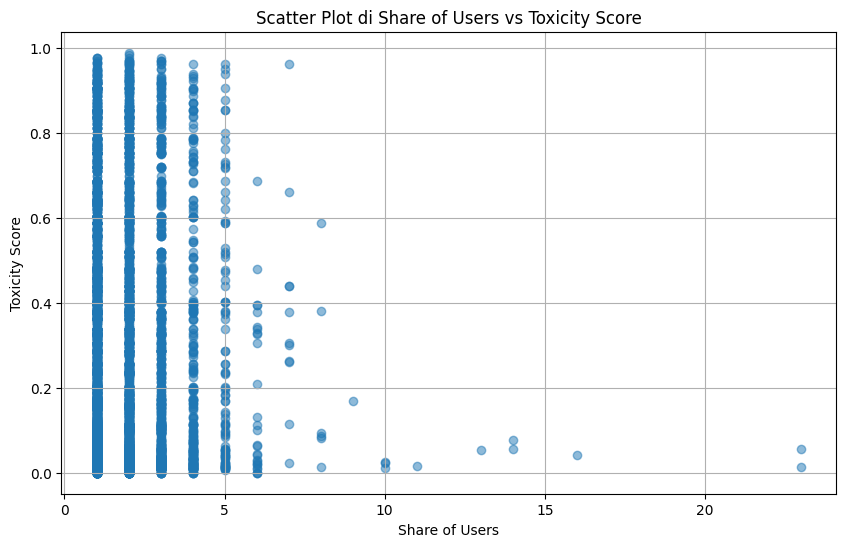

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(shares_of_users, toxs, alpha=0.5)
plt.title('Scatter Plot di Share of Users vs Toxicity Score')
plt.xlabel('Share of Users')
plt.ylabel('Toxicity Score')
plt.grid(True)
plt.show()

<Figure size 1000x600 with 0 Axes>

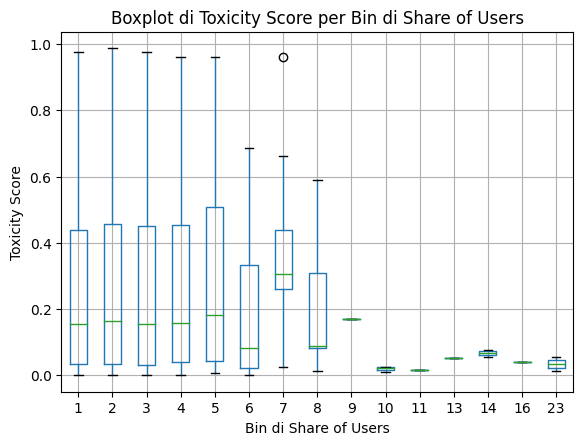

In [ ]:
# Creazione dei bin
bins = pd.cut(shares_of_users, bins=20)

# Creazione del dataframe per facilitare il plotting
plot_data = pd.DataFrame({'Share of Users': shares_of_users, 'Toxicity Score': toxs})

# Creazione dei boxplot
plt.figure(figsize=(10, 6))
plot_data.boxplot(column='Toxicity Score', by='Share of Users')
plt.title('Boxplot di Toxicity Score per Bin di Share of Users')
plt.suptitle('')  # Rimuove il titolo automatico di Pandas
plt.xlabel('Bin di Share of Users')
plt.ylabel('Toxicity Score')
plt.grid(True)
plt.show()

## Concentrazione della tossicità

## Su yt

In [ ]:
import pandas as pd
import dask.dataframe as dd

# Try different encodings until successful read
encodings_to_try = ['latin1']

ddf = dd.read_parquet('/content/drive/MyDrive/thesis/data/youtube/youtube_labeled_data_unified.parquet',
                               engine='pyarrow', encoding=encoding)
post_ids = ddf.post_id
post_ids = post_ids.compute()

filtered_ddf = ddf[ddf['post_id'].isin(post_ids.sample(10000))]
yt = filtered_ddf.compute()
yt = pd.DataFrame(yt)

yt['user_id'] = pd.factorize(yt['user_name'])[0]



,comment_id,user_name,like_count,created_at,post_id,parent_id,social,topic,toxicity_score,user_id
1069,UgxCiGnoAOL5c0KBWzJ4AaABAg,Mike,0,2021-10-15T10:31:50Z,-3x0ji-5V4c,<NA>,YouTube,Climate Change,0.419501,0
1070,Ugyxu4SDcS64S7Bxuid4AaABAg,LOON RANGER,0,2021-10-15T09:29:28Z,-3x0ji-5V4c,<NA>,YouTube,Climate Change,0.343884,1
1071,UgyxbmOyjNht-OoStGF4AaABAg,Mark Fox,0,2021-10-15T09:17:46Z,-3x0ji-5V4c,<NA>,YouTube,Climate Change,0.116009,2
1072,UgyWpOmOyJeUhEuRZeV4AaABAg,Jon Harris,1,2021-10-15T08:31:20Z,-3x0ji-5V4c,<NA>,YouTube,Climate Change,0.079307,3
1073,Ugy3fw4ahZ84LeSAE5B4AaABAg,CodeJunkie,0,2021-10-15T08:29:40Z,-3x0ji-5V4c,<NA>,YouTube,Climate Change,0.143735,4
...,...,...,...,...,...,...,...,...,...,...
962694,UgyWwytkoxUkueDfm5N4AaABAg.9DgNfgJKd3k9DgPGRF6j28,Ã°ÂÂÂ¹ Robeon Mew Ã°ÂÂÂ°,1,2020-09-17T00:14:07Z,Bi_Tp1H9CDs,UgyWwytkoxUkueDfm5N4AaABAg,YouTube,Vaccines,0.042002,3215202
962695,UgzQpxcZYsym72XV_hJ4AaABAg.9DfiP8hcEl49OwEtSweeeU,Sea of Tranquility,0,2021-06-23T13:36:38Z,Bi_Tp1H9CDs,UgzQpxcZYsym72XV_hJ4AaABAg,YouTube,Vaccines,0.068919,1457125
962696,UgzQpxcZYsym72XV_hJ4AaABAg.9DfiP8hcEl49NggkgTAHcQ,Andrew_koala,0,2021-05-23T16:09:36Z,Bi_Tp1H9CDs,UgzQpxcZYsym72XV_hJ4AaABAg,YouTube,Vaccines,0.027581,571291
962697,UgzQpxcZYsym72XV_hJ4AaABAg.9DfiP8hcEl49IY-BTpU3YF,Carl Angelo,0,2021-01-15T15:10:03Z,Bi_Tp1H9CDs,UgzQpxcZYsym72XV_hJ4AaABAg,YouTube,Vaccines,0.158015,2842133


In [ ]:
yt=result

<ipython-input-37-b31431956a8a>:41: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  markerline, stemlines, baseline = ax.stem(bin_centers, bin_stats['fraction_overall_toxicity'], 'r', markerfmt='ro', basefmt=" ", use_line_collection=True)


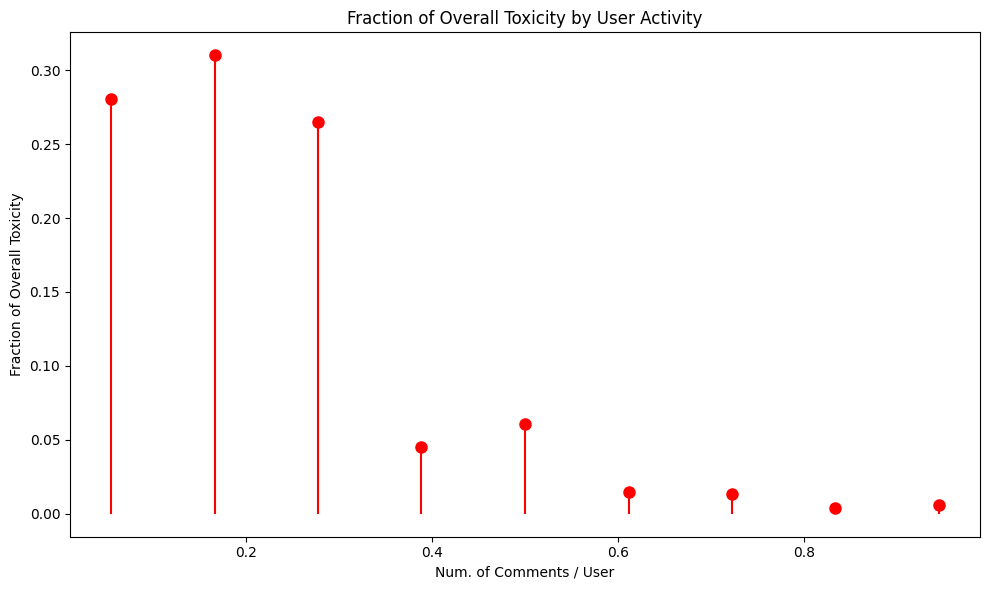

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Supponiamo che il dataset sia caricato in un DataFrame chiamato 'df'
# df = pd.read_csv('path_to_your_data.csv')

# Dati di esempio (sostituisci con i tuoi dati reali)
# Per esempio: df = pd.read_csv('your_dataset.csv')

# 1. Aggiungi la variabile 'is_toxic'
yt['is_toxic'] = yt['toxicity_score'] > 0.6

# 2. Aggrega per utente
user_stats = yt.groupby('user').agg(
    num_comments=('comment_id', 'count'),
    num_toxic_comments=('is_toxic','sum'),
    mean_toxic_comment=('is_toxic', 'mean')
).reset_index()

numero_commenti_tossici=user_stats.num_toxic_comments.sum()
user_stats['mean_toxic_comment']=(user_stats['mean_toxic_comment'])

# 3. Calcola la frazione di tossicità complessiva per intervalli di attività degli utenti
bins = np.linspace(0, 1, 10)  # 5 bin omogenei tra minimo e massimo
user_stats['bin'] = pd.cut(user_stats['mean_toxic_comment'], bins)
bin_stats = user_stats.groupby('bin').agg(
    fraction_overall_toxicity=('num_comments', 'count'),
).reset_index()

# Fai la frazione rispetto
bin_stats['fraction_overall_toxicity']=bin_stats['fraction_overall_toxicity']/bin_stats.fraction_overall_toxicity.sum()

# Calcola il centro di ciascun bin
bin_centers = bin_stats['bin'].apply(lambda x: x.mid).to_list()

# 4. Creazione del grafico a barre lollipop
fig, ax = plt.subplots(figsize=(10, 6))

# Grafico a lollipop: Fraction of overall toxicity contributed by users with different levels of toxicity
markerline, stemlines, baseline = ax.stem(bin_centers, bin_stats['fraction_overall_toxicity'], 'r', markerfmt='ro', basefmt=" ", use_line_collection=True)
ax.set_xlabel('Num. of Comments / User')
ax.set_ylabel('Fraction of Overall Toxicity')
ax.set_title('Fraction of Overall Toxicity by User Activity')

# Personalizza lo stile del lollipop
plt.setp(stemlines, 'color', 'r', 'linewidth', 1.5)
plt.setp(markerline, 'markersize', 8)

plt.tight_layout()
plt.show()


In [ ]:

grouped = yt.groupby('user')['is_toxic'].sum().reset_index()

# Ordinare i valori risultanti
sorted_values = grouped['is_toxic'].sort_values().values

# Calcolare la curva di Lorenz
cumulative_values = np.cumsum(sorted_values)
total = cumulative_values[-1]
lorenz_curve = np.insert(cumulative_values / total, 0, 0)  # Aggiungere 0 all'inizio della curva

# Calcolare l'area sotto la curva di Lorenz
lorenz_area = np.trapz(lorenz_curve, dx=1/len(lorenz_curve))

# Calcolare l'indice di Gini
gini_index = 1 - 2 * lorenz_area

print("Indice di Gini:", gini_index)

Indice di Gini: 0.8188299186445376


In [ ]:
# Ordina il DataFrame in base alla colonna 'is_toxic' in ordine decrescente
top_100_toxic_users = grouped.sort_values(by='is_toxic', ascending=False).head(1000)

# Visualizza i primi 100 utenti più tossici
list_top_100_toxic_users=top_100_toxic_users['user']

print('i cento utenti più tossici rappresentano il '+str(round(grouped[grouped['user'].isin(list_top_100_toxic_users)]['is_toxic'].sum()/grouped['is_toxic'].sum(),2)))

i cento utenti più tossici rappresentano il 0.2


In [ ]:
# Creazione del vocabolario utente -> root_submission_set
vocabolario = {}
vocabolario_toxic = {}

yt_toxic=yt[yt['is_toxic']] #seleziono solo interazioni tossiche
for toxic_user in tqdm(list_top_100_toxic_users):
    root_submissions = set(yt[yt['user'] == toxic_user]['post_id'])
    root_submissions_toxic = set(yt_toxic[yt_toxic['user'] == toxic_user]['post_id'])
    vocabolario[toxic_user] = root_submissions
    vocabolario_toxic[toxic_user]= root_submissions_toxic

100%|██████████| 1000/1000 [00:07<00:00, 129.88it/s]


100%|██████████| 1000/1000 [00:01<00:00, 883.96it/s]


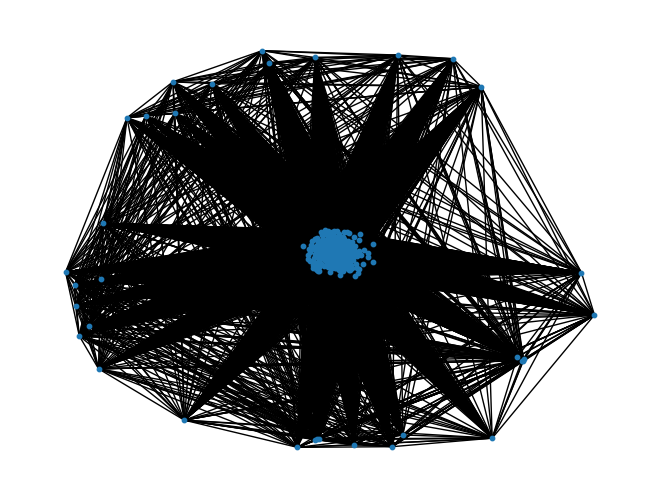

In [ ]:
import networkx as nx

# Creazione di una lista vuota per i dati delle coppie di utenti
data = []

# Calcolo del numero di thread in comune per ogni coppia di utenti
for user1 in tqdm(vocabolario_toxic):
    for user2 in vocabolario_toxic:
        if user1 != user2:
            root_submissions_in_comune = vocabolario_toxic[user1].intersection(vocabolario[user2])
            data.append({'Utente 1': user1, 'Utente 2': user2, 'Thread in comune': len(root_submissions_in_comune)})

# Creazione del DataFrame
df = pd.DataFrame(data)

# Creazione del grafo
G = nx.Graph()

# Aggiunta dei nodi al grafo
G.add_nodes_from(df['Utente 1'])
G.add_nodes_from(df['Utente 2'])

# Aggiunta degli archi al grafo con il peso del numero di thread in comune
for index, row in df.iterrows():
    G.add_edge(row['Utente 1'], row['Utente 2'], weight=row['Thread in comune'])

# Disegno del grafo con etichette degli archi
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=False, node_size=10, font_size=10)

plt.show()


In [ ]:
edges_with_weights = nx.get_edge_attributes(G, 'weight')
strongest_edge = max(edges_with_weights, key=edges_with_weights.get)

# Output the strongest edge and its weight
print("The strongest edge is:", strongest_edge)
print("The weight of the strongest edge is:", edges_with_weights[strongest_edge])

The strongest edge is: (1872, 171)
The weight of the strongest edge is: 23


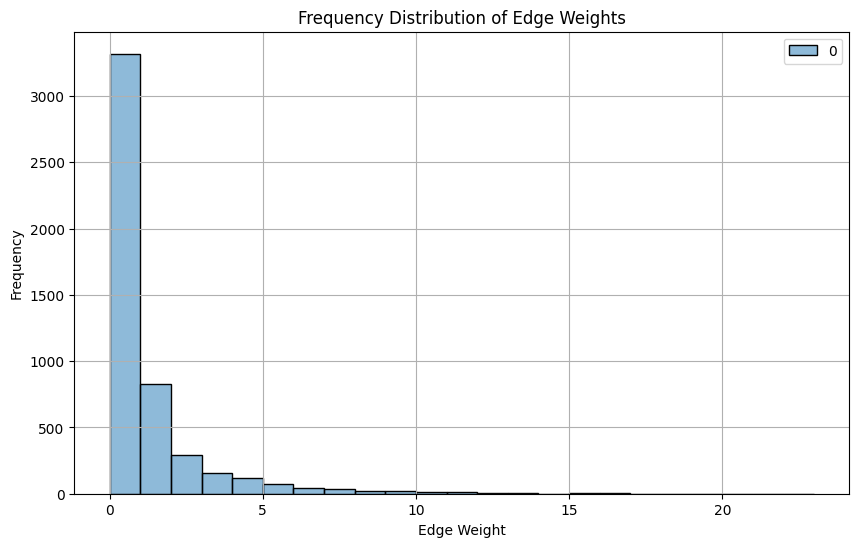

In [ ]:
edge_weights = nx.get_edge_attributes(G, 'weight').values()

# Plot the frequency distribution of edge weights
plt.figure(figsize=(10, 6))
sns.histplot(edge_weights, bins=range(min(edge_weights), max(edge_weights) + 1), kde=False)
plt.title('Frequency Distribution of Edge Weights')
plt.xlabel('Edge Weight')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Su Voat

In [ ]:
voat=pd.read_parquet('/content/drive/MyDrive/thesis/data/voat/voat_labeled_data_unified.parquet')

<ipython-input-49-ea5fc2aef936>:41: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  markerline, stemlines, baseline = ax.stem(bin_centers, bin_stats['fraction_overall_toxicity'], 'r', markerfmt='ro', basefmt=" ", use_line_collection=True)


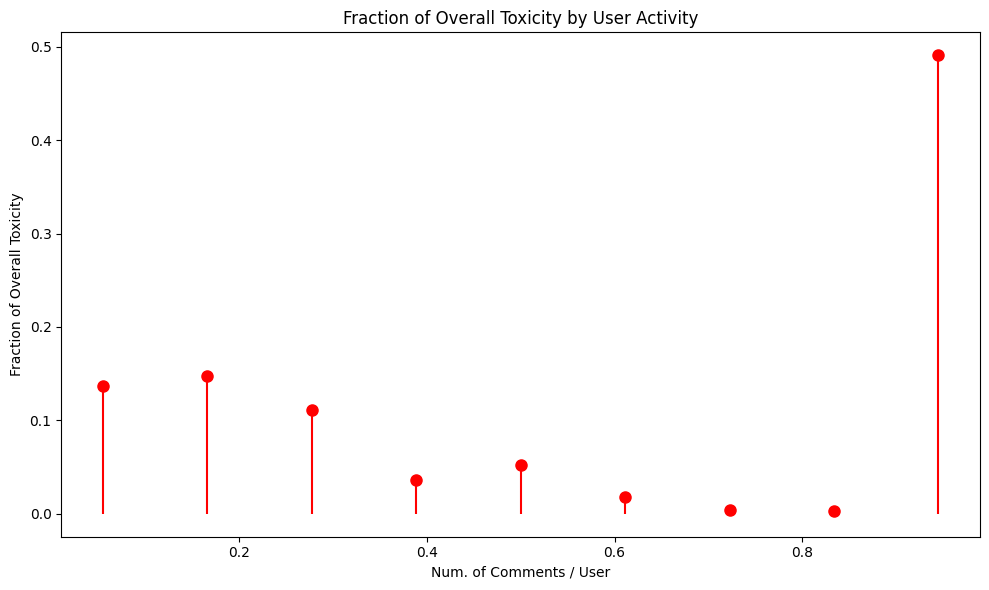

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Supponiamo che il dataset sia caricato in un DataFrame chiamato 'df'
# df = pd.read_csv('path_to_your_data.csv')

# Dati di esempio (sostituisci con i tuoi dati reali)
# Per esempio: df = pd.read_csv('your_dataset.csv')

# 1. Aggiungi la variabile 'is_toxic'
voat['is_toxic'] = voat['toxicity_score'] > 0.6

# 2. Aggrega per utente
user_stats = voat.groupby('user').agg(
    num_comments=('comment_id', 'count'),
    num_toxic_comments=('is_toxic','sum'),
    mean_toxic_comment=('is_toxic', 'mean')
).reset_index()

numero_commenti_tossici=user_stats.num_toxic_comments.sum()
user_stats['mean_toxic_comment']=(user_stats['mean_toxic_comment'])

# 3. Calcola la frazione di tossicità complessiva per intervalli di attività degli utenti
bins = np.linspace(0, 1, 10)  # 5 bin omogenei tra minimo e massimo
user_stats['bin'] = pd.cut(user_stats['mean_toxic_comment'], bins)
bin_stats = user_stats.groupby('bin').agg(
    fraction_overall_toxicity=('num_comments', 'count'),
).reset_index()

# Fai la frazione rispetto
bin_stats['fraction_overall_toxicity']=bin_stats['fraction_overall_toxicity']/bin_stats.fraction_overall_toxicity.sum()

# Calcola il centro di ciascun bin
bin_centers = bin_stats['bin'].apply(lambda x: x.mid).to_list()

# 4. Creazione del grafico a barre lollipop
fig, ax = plt.subplots(figsize=(10, 6))

# Grafico a lollipop: Fraction of overall toxicity contributed by users with different levels of toxicity
markerline, stemlines, baseline = ax.stem(bin_centers, bin_stats['fraction_overall_toxicity'], 'r', markerfmt='ro', basefmt=" ", use_line_collection=True)
ax.set_xlabel('Num. of Comments / User')
ax.set_ylabel('Fraction of Overall Toxicity')
ax.set_title('Fraction of Overall Toxicity by User Activity')

# Personalizza lo stile del lollipop
plt.setp(stemlines, 'color', 'r', 'linewidth', 1.5)
plt.setp(markerline, 'markersize', 8)

plt.tight_layout()
plt.show()


In [ ]:
grouped = voat.groupby('user')['is_toxic'].sum().reset_index()

# Ordinare i valori risultanti
sorted_values = grouped['is_toxic'].sort_values().values

# Calcolare la curva di Lorenz
cumulative_values = np.cumsum(sorted_values)
total = cumulative_values[-1]
lorenz_curve = np.insert(cumulative_values / total, 0, 0)  # Aggiungere 0 all'inizio della curva

# Calcolare l'area sotto la curva di Lorenz
lorenz_area = np.trapz(lorenz_curve, dx=1/len(lorenz_curve))

# Calcolare l'indice di Gini
gini_index = 1 - 2 * lorenz_area

print("Indice di Gini:", gini_index)

Indice di Gini: 0.9597573235701226


è ingiusto il confronto tra utenti che hanno diversi livelli di attvità per questo valutiamo, l'indice di gini a parità di numero di commenti totale.

In [ ]:
import numpy as np
import pandas as pd

# Definizione delle soglie da testare
threshold_values = [1, 2, 3, 4, 5,6,7,8,9,10,15,20,25]  # Esempio di soglie da 1 a 5

# Inizializzazione di una lista per memorizzare gli indici di Gini per ogni soglia
gini_indices = []

# Calcolo dell'indice di Gini per ogni soglia
for threshold in tqdm(threshold_values):
    # Selezionare solo gli utenti con un certo livello di attività (soglia)
    users_activity = voat.groupby(['user'])['comment_id'].count().reset_index()
    active_users = users_activity[users_activity['comment_id'] == threshold]['user']
    voat_filtered = voat[voat['user'].isin(active_users)]

    # Calcolo dell'indice di Gini
    grouped = voat_filtered.groupby('user')['is_toxic'].sum().reset_index()
    sorted_values = grouped['is_toxic'].sort_values().values
    cumulative_values = np.cumsum(sorted_values)
    total = cumulative_values[-1]
    lorenz_curve = np.insert(cumulative_values / total, 0, 0)
    lorenz_area = np.trapz(lorenz_curve, dx=1/len(lorenz_curve))
    gini_index = 1 - 2 * lorenz_area

    # Aggiungi l'indice di Gini alla lista
    gini_indices.append(gini_index)

# Costruzione della tabella dei risultati
results_table = pd.DataFrame({'Threshold': threshold_values, 'Gini Index': gini_indices})

print(results_table)


100%|██████████| 13/13 [00:14<00:00,  1.12s/it]

    Threshold  Gini Index
0           1    0.815252
1           2    0.824051
2           3    0.748047
3           4    0.698366
4           5    0.672111
5           6    0.659769
6           7    0.627942
7           8    0.599424
8           9    0.585766
9          10    0.590502
10         15    0.526723
11         20    0.511836
12         25    0.463733


Se prendessimo i 100 utenti piu tossici, quanta percentuale di commenti elimineremmo.

In [ ]:
# Ordina il DataFrame in base alla colonna 'is_toxic' in ordine decrescente
top_100_toxic_users = grouped.sort_values(by='is_toxic', ascending=False).head(100)

# Visualizza i primi 100 utenti più tossici
list_top_100_toxic_users=top_100_toxic_users['user']

print('i cento utenti più tossici rappresentano il '+str(round(grouped[grouped['user'].isin(list_top_100_toxic_users)]['is_toxic'].sum()/grouped['is_toxic'].sum(),2)))

i cento utenti più tossici rappresentano il 0.79


In [ ]:
# Creazione del vocabolario utente -> root_submission_set
vocabolario = {}

for toxic_user in tqdm(list_top_100_toxic_users):
    root_submissions = set(voat[voat['user'] == toxic_user]['root_submission'])
    vocabolario[toxic_user] = root_submissions


100%|██████████| 100/100 [00:52<00:00,  1.91it/s]


100%|██████████| 100/100 [00:00<00:00, 4679.78it/s]


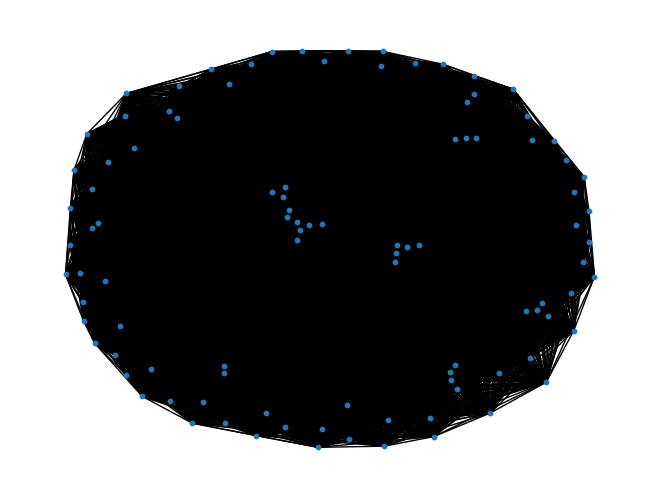

In [ ]:


# Creazione di una lista vuota per i dati delle coppie di utenti
data = []

# Calcolo del numero di thread in comune per ogni coppia di utenti
for user1 in tqdm(vocabolario):
    for user2 in vocabolario:
        if user1 != user2:
            root_submissions_in_comune = vocabolario[user1].intersection(vocabolario[user2])
            data.append({'Utente 1': user1, 'Utente 2': user2, 'Thread in comune': len(root_submissions_in_comune)})

# Creazione del DataFrame
df = pd.DataFrame(data)

# Creazione del grafo
G = nx.Graph()

# Aggiunta dei nodi al grafo
G.add_nodes_from(df['Utente 1'])
G.add_nodes_from(df['Utente 2'])

# Aggiunta degli archi al grafo con il peso del numero di thread in comune
for index, row in df.iterrows():
    G.add_edge(row['Utente 1'], row['Utente 2'], weight=row['Thread in comune'])

# Disegno del grafo con etichette degli archi
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=False, node_size=10, font_size=10)

plt.show()


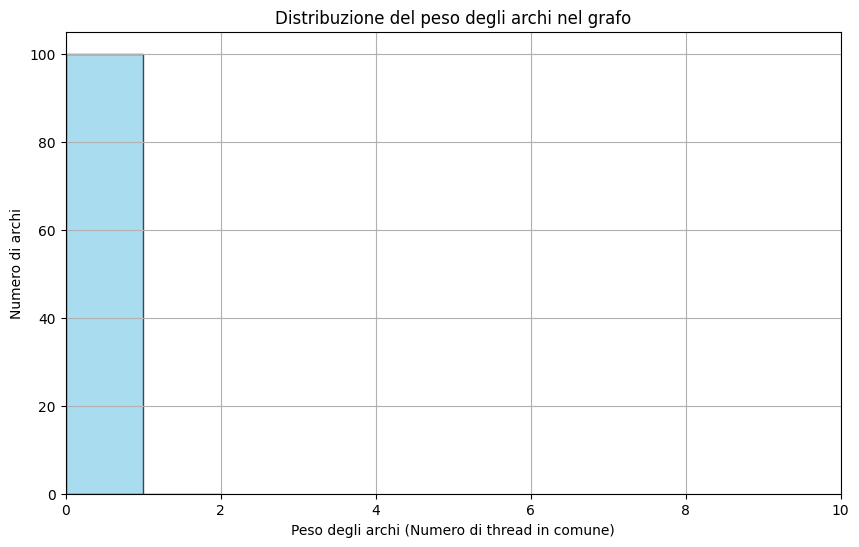

In [ ]:
# Estrazione dei pesi degli archi
edge_weights = nx.get_edge_attributes(G, 'weight').values()
edge_weight_freq_rel = [count / total_edges for count in edge_weight_counts]

# Creazione del plot
plt.figure(figsize=(10, 6))
plt.hist(edge_weight_freq_rel, bins=range(min(edge_weights), max(edge_weights) + 1, 1), alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Peso degli archi (Numero di thread in comune)')
plt.ylabel('Numero di archi')
plt.title('Distribuzione del peso degli archi nel grafo')
plt.grid(True)
plt.xlim(0,10)
plt.show()
